## 🧰 Cell 1 — Configuration & Run Logger

This cell sets up **project configuration**, **dependencies**, and a lightweight **run logger** to standardize how each pipeline step is executed and recorded.

In [4]:
import os, sys, time, json, traceback, warnings, math, uuid, random
from datetime import datetime
import numpy as np
import pandas as pd
from IPython.display import display, Markdown  # ✅ to print formatted cell output

from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    precision_recall_curve, roc_curve, r2_score, mean_squared_error,
    classification_report, silhouette_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.cluster import KMeans

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import xgboost as xgb
from bayes_opt import BayesianOptimization

import joblib
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# =============================
#  CONFIGURATION
# =============================
INPUT_PATH = "D:/CAREER/INTERVIEWS/Play Simple Games/Case Study/PSG_ML Solution/Model Input/GamingData_Input_v6.csv"
OUTPUT_DIR = "D:/CAREER/INTERVIEWS/Play Simple Games/Case Study/PSG_ML Solution/Model Outputs/Model_Outputs_102125_v3"
os.makedirs(OUTPUT_DIR, exist_ok=True)

RANDOM_STATE = 2025
DEBUG = True
np.random.seed(RANDOM_STATE)

# =============================
#  DETAILED LOGGER
# =============================
def run_step(step_name: str):
    class _Logger:
        def __init__(self, name):
            safe = name.lower().replace(" ", "_")
            self.log_path = os.path.join(OUTPUT_DIR, f"{safe}_log.txt")
            self.name = name
            self.fp = None
            self.t0 = None

        def __enter__(self):
            self.t0 = time.time()
            self.fp = open(self.log_path, "w", encoding="utf-8")
            start_msg = f"[START] {self.name} @ {datetime.now():%Y-%m-%d %H:%M:%S}"
            self._write(start_msg)
            #display(Markdown(f"### 🚀 Step Started: **{self.name}**  \n🕒 {datetime.now():%Y-%m-%d %H:%M:%S}"))
            return self

        def log(self, msg, level="INFO"):
            timestamp = datetime.now().strftime("%H:%M:%S")
            formatted = f"[{level}] {timestamp} — {msg}"
            self._write(formatted)
            #display(Markdown(f"✅ `{formatted}`"))

        def warn(self, msg):
            self.log(msg, level="WARN")

        def error(self, msg):
            self.log(msg, level="ERROR")

        def _write(self, msg):
            self.fp.write(msg.rstrip() + "\n")
            self.fp.flush()  # ✅ continuously flush to file
            if DEBUG:
                print(msg)

        def __exit__(self, exc_type, exc, tb):
            dt = time.time() - self.t0
            if exc_type is None:
                end_msg = f"[END] {self.name} — ✅ OK — runtime: {dt:.2f}s"
                self._write(end_msg)
                # display(Markdown(f"### ✅ Step Completed: **{self.name}** in `{dt:.2f}`s"))
            else:
                err_msg = "".join(traceback.format_exception(exc_type, exc, tb))
                self._write("[ERROR] " + err_msg)
                self._write(f"[END] {self.name} — ❌ FAILED — runtime: {dt:.2f}s")
                # display(Markdown(f"### ❌ Step Failed: **{self.name}**  \n```\n{err_msg}\n```"))
            self.fp.close()
            return False

    return _Logger(step_name)

## 📥 Cell 2 — Data Loading & Preprocessing

This cell handles **data ingestion, schema validation, and preprocessing** to ensure that raw telemetry data is clean, consistent, and ready for feature engineering.

In [5]:
REQUIRED_COLS = [
    "user_id","country","device_type","session_id","session_duration","level_reached",
    "ad_type","ad_placement","time_of_day","frequency","impressions","clicks",
    "game_time_post_ad","retention_next_day","spend_after_ad","churn_probability",
    "ad_revenue_per_impression","lifetime_value_estimate","event_time"
]

with run_step("02_data_load_preprocessing") as log:
    if not os.path.exists(INPUT_PATH):
        raise FileNotFoundError(f"Input CSV not found: {INPUT_PATH}")
    df = pd.read_csv(INPUT_PATH)
    log.log(f"Loaded shape: {df.shape}")

    missing = [c for c in REQUIRED_COLS if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

    df = df.dropna(subset=["user_id","session_id","event_time"]).copy()
    df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")
    df = df.dropna(subset=["event_time"]).copy()
    df = df.sort_values(["user_id","event_time"]).reset_index(drop=True)

    for c in ["country","device_type","ad_type","ad_placement"]:
        df[c] = df[c].astype("category")

    df["retention_next_day"] = df["retention_next_day"].astype(int).clip(0,1)

    df.head(10).to_csv(os.path.join(OUTPUT_DIR, "sample_input_head.csv"), index=False)
    df.describe().to_csv(os.path.join(OUTPUT_DIR, "input_describe.csv"))
    log.log(f"Final cleaned shape: {df.shape}")

[START] 02_data_load_preprocessing @ 2025-10-21 20:31:48
[INFO] 20:31:48 — Loaded shape: (201506, 19)
[INFO] 20:31:49 — Final cleaned shape: (201506, 19)
[END] 02_data_load_preprocessing — ✅ OK — runtime: 0.65s


## 🧱 Cell 3 — Feature Engineering & User-Level Aggregations

This cell converts raw event-level telemetry into **model-ready features**, and rolls up signals to the **user level** for retention, churn, segmentation, and policy learning.

In [6]:
with run_step("03_feature_engineering") as log:
    fe = df.copy()
    fe["dow"] = fe["event_time"].dt.dayofweek
    fe["is_weekend"] = (fe["dow"] >= 5).astype(int)
    fe["ctr"] = (fe["clicks"] / fe["impressions"].replace(0, np.nan)).fillna(0.0).clip(0,1)

# This block summarizes raw event-level telemetry into user-level metrics.
    # It transforms messy clickstream data into structured behavioral indicators — enabling:
    # Retention modeling
    # Ad engagement prediction
    # Player segmentation
    # LTV (lifetime value) or churn analysis
    user_agg = fe.groupby("user_id").agg(
        sessions_played=("session_id","nunique"),
        total_impressions=("impressions","sum"),
        total_clicks=("clicks","sum"),
        mean_session_duration=("session_duration","mean"),
        median_frequency=("frequency","median"),
        mean_post_ad_time=("game_time_post_ad","mean"),
        mean_churn_prob=("churn_probability","mean"),
        mean_spend=("spend_after_ad","mean"),
    ).reset_index()

    fe = fe.merge(user_agg, on="user_id", how="left")

    CATS = ["country","device_type","ad_type","ad_placement"]
    NUMS = [
        "session_duration","level_reached","time_of_day","frequency","impressions","clicks",
        "game_time_post_ad","ad_revenue_per_impression","lifetime_value_estimate","dow","is_weekend",
        "sessions_played","total_impressions","total_clicks","mean_session_duration",
        "median_frequency","mean_post_ad_time","mean_churn_prob","mean_spend"
    ]

    X_all = fe[CATS + NUMS].copy()
    y_ret = fe["retention_next_day"].astype(int)
    y_churn = fe["churn_probability"].astype(float)
    groups = fe["user_id"].values

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline(steps=[
                ("impute", SimpleImputer(strategy="median")),
                ("scale", StandardScaler())
            ]), NUMS),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), CATS)
        ]
    )

    with open(os.path.join(OUTPUT_DIR, "feature_metadata.json"), "w") as f:
        json.dump({"categoricals":CATS,"numericals":NUMS}, f, indent=2)

    log.log("Engineered features. X_all shape: {} | y_ret: {} | y_churn: {}".format(X_all.shape, y_ret.shape, y_churn.shape))

[START] 03_feature_engineering @ 2025-10-21 20:32:27
[INFO] 20:32:27 — Engineered features. X_all shape: (201506, 23) | y_ret: (201506,) | y_churn: (201506,)
[END] 03_feature_engineering — ✅ OK — runtime: 0.29s


## 🧩 Cell 4 — Train/Test Split Strategy (Group-Aware CV)

This cell implements a **group-aware train/test split** using `GroupKFold`, ensuring that **all data from the same player or session group** stays together within either the training or test set.  
This prevents **data leakage** and ensures fair evaluation for user-level behavioral modeling.

In [7]:
with run_step("04_split_strategy") as log:
    gkf = GroupKFold(n_splits=5)
    tr_idx, te_idx = next(gkf.split(X_all, y_ret, groups=groups))

    X_train, X_test = X_all.iloc[tr_idx], X_all.iloc[te_idx]
    y_ret_train, y_ret_test = y_ret.iloc[tr_idx], y_ret.iloc[te_idx]
    y_churn_train, y_churn_test = y_churn.iloc[tr_idx], y_churn.iloc[te_idx]

    pd.DataFrame({"train_idx": tr_idx}).to_csv(os.path.join(OUTPUT_DIR,"train_indices.csv"), index=False)
    pd.DataFrame({"test_idx": te_idx}).to_csv(os.path.join(OUTPUT_DIR,"test_indices.csv"), index=False)

    log.log(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

[START] 04_split_strategy @ 2025-10-21 20:33:17
[INFO] 20:33:18 — Train size: 161204 | Test size: 40302
[END] 04_split_strategy — ✅ OK — runtime: 0.14s


## 🧩 Cell 5 — Player Segmentation (K-Means) + Mini Grid Search

This cell builds **player segments** from user-level aggregates using **K-Means**, with a **minimal grid search** for speed.  
It evaluates configurations via **silhouette score**, saves the best model, and writes segment labels back to the feature table.

In [ ]:
with run_step("05_player_segmentation") as log:

    # features & preprocessing
    seg_features = ["mean_session_duration","median_frequency","mean_post_ad_time","mean_spend","mean_churn_prob"]
    seg_df = fe[seg_features].fillna(0.0)
    scaler_seg = StandardScaler()
    X_seg = scaler_seg.fit_transform(seg_df)

    # Hyperparameter grid (minimal for quick run: fixed to one best config)
    cluster_range = [4]              # Fixed to 4 (prior best)
    n_init_options = [1]             # Reduced to 1 for speed (less stable, but quick)
    max_iter_options = [100]         # Reduced for faster convergence
    algorithms = ["lloyd"]           # Fixed to one efficient alg (elkan may warn on small data)

    best_score = -1.0
    best_params = None
    best_model = None

    results = []
    for k in cluster_range:
        for n_init in n_init_options:
            for max_iter in max_iter_options:
                for alg in algorithms:
                    log.log(f"Starting KMeans with k={k}, n_init={n_init}, max_iter={max_iter}, alg={alg}")
                    try:
                        km = KMeans(
                            n_clusters=k,
                            init="k-means++",
                            n_init=n_init,
                            max_iter=max_iter,
                            tol=1e-4,
                            algorithm=alg,
                            random_state=RANDOM_STATE,
                            verbose=1,
                        )
                        labels = km.fit_predict(X_seg)
                        # silhouette requires at least 2 clusters and less clusters than samples
                        if len(set(labels)) < 2:
                            continue
                        sil = silhouette_score(X_seg, labels)
                        results.append({
                            "n_clusters": k,
                            "n_init": n_init,
                            "max_iter": max_iter,
                            "algorithm": alg,
                            "silhouette": sil,
                            "inertia": float(km.inertia_),
                        })
                        # keep best
                        if sil > best_score:
                            best_score = sil
                            best_params = {"n_clusters": k, "n_init": n_init, "max_iter": max_iter, "algorithm": alg}
                            best_model = km
                    except Exception as e:
                        # log but continue (e.g., numerical issues)
                        log.log(f"Warning: KMeans failed for k={k}, n_init={n_init}, max_iter={max_iter}, alg={alg} -> {e}")

    # save grid results for inspection (minimal, so quick)
    res_df = pd.DataFrame(results).sort_values("silhouette", ascending=False).reset_index(drop=True)
    res_df.to_csv(os.path.join(OUTPUT_DIR, "kmeans_hypergrid_results.csv"), index=False)

    if best_model is None:
        log.log("No valid KMeans model found during grid search. Falling back to default parameters.")
        best_model = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=1).fit(X_seg)  # Quick fallback
        fe["player_segment"] = best_model.predict(X_seg)
        final_sil = silhouette_score(X_seg, fe["player_segment"])
        pd.DataFrame({"silhouette_score": [final_sil]}).to_csv(os.path.join(OUTPUT_DIR, "segment_silhouette.csv"), index=False)
        fe.to_csv(os.path.join(OUTPUT_DIR, "features_with_segments.csv"), index=False)
        log.log(f"Fallback Silhouette Score: {final_sil:.4f}")
    else:
        # assign best segmentation
        fe["player_segment"] = best_model.predict(X_seg)
        final_sil = best_score
        # save best params and scores
        pd.DataFrame([best_params]).to_csv(os.path.join(OUTPUT_DIR, "best_kmeans_params.csv"), index=False)
        pd.DataFrame({"silhouette_score": [final_sil]}).to_csv(os.path.join(OUTPUT_DIR, "segment_silhouette.csv"), index=False)
        fe.to_csv(os.path.join(OUTPUT_DIR, "features_with_segments.csv"), index=False)
        log.log(f"Best KMeans params: {best_params} | Silhouette Score: {final_sil:.4f}")

    # quick summary print for run log
    if not res_df.empty:
        top = res_df.head(3)
        log.log(f"Top 3 configurations (silhouette):\n{top.to_dict(orient='records')}")

[START] 05_player_segmentation @ 2025-10-21 20:55:49
[INFO] 20:55:49 — Starting KMeans with k=4, n_init=1, max_iter=100, alg=lloyd
Initialization complete
Iteration 0, inertia 699791.6960711272.
Iteration 1, inertia 620547.7685478099.
Iteration 2, inertia 613164.5193163005.
Iteration 3, inertia 609861.9335447487.
Iteration 4, inertia 608101.5129754782.
Iteration 5, inertia 607265.4290105602.
Iteration 6, inertia 606876.1511114766.
Iteration 7, inertia 606669.421826335.
Iteration 8, inertia 606543.1394906562.
Iteration 9, inertia 606449.8755559075.
Iteration 10, inertia 606376.5888717218.
Iteration 11, inertia 606249.8482903278.
Iteration 12, inertia 606101.4167032257.
Iteration 13, inertia 605948.7582751218.
Iteration 14, inertia 605835.0505063343.
Iteration 15, inertia 605726.4152442178.
Iteration 16, inertia 605608.5254844795.
Iteration 17, inertia 605521.6205068658.
Iteration 18, inertia 605437.8547215393.
Iteration 19, inertia 605390.1061344806.
Iteration 20, inertia 605328.2074315

## 🏷️ Cell 5a — Naming Clusters & Profiling Segments

This cell assigns **human-readable names** to K-Means clusters and builds **segment profiles** to understand how each segment differs across key numeric features.

In [10]:

# --- Input/Output paths ---
input_path = os.path.join(OUTPUT_DIR, "features_with_segments.csv")   # or your save path
output_path = input_path.replace(".csv", "_cluster_names.csv")

# --- Load the clustered features ---
df = pd.read_csv(input_path)

# --- Identify the cluster column ---
# Adjust if your column name differs (e.g., 'segment', 'cluster_id', etc.)
seg_col = None
for c in df.columns:
    if c.lower() in (
        "segment", "cluster", "label", 
        "segment_id", "kmeans_segment", 
        "cluster_id", "player_segment"
    ):
        seg_col = c
        break

if seg_col is None:
    raise ValueError("No cluster column found in features_with_segments.csv")

# --- Map descriptive names to each cluster ---
cluster_name_map = {
    0: "Engaged Low-Spenders",
    1: "Casual / Light Users",
    2: "Highly Engaged / Potential Whales",
    3: "At-risk / Short-term Engagers"
}

df["cluster_name"] = df[seg_col].map(cluster_name_map)

# --- Save updated dataset ---
df.to_csv(output_path, index=False)

print(f"✅ Cluster names added and saved to: {output_path}")
print("Cluster mapping:")
for k, v in cluster_name_map.items():
    print(f"  {k}: {v}")


input_path = os.path.join(OUTPUT_DIR, "features_with_segments_cluster_names.csv")
out_summary_csv = os.path.join(OUTPUT_DIR, "features_by_cluster_summary.csv")
out_topfeats_csv = os.path.join(OUTPUT_DIR, "cluster_top_features.csv")

df = pd.read_csv(input_path)

# Detect cluster name column
cluster_col = "cluster_name" if "cluster_name" in df.columns else "player_segment"

# Identify numeric features to summarize
exclude = {"user_id","session_id","country","device_type","ad_type",
           "ad_placement","event_time","cluster_name","player_segment"}
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude]

# Grouped summary: count + means
grouped = df.groupby(cluster_col)[numeric_cols].agg(['count','mean','std','median'])
grouped.columns = ["_".join(col).strip() for col in grouped.columns.values]
grouped = grouped.reset_index()
grouped.to_csv(out_summary_csv, index=False)
print(f"✅ Saved numeric summary to: {out_summary_csv}")

# Compute top positive/negative feature deviations
overall_mean = df[numeric_cols].mean()
summary_list = []
for cl, sub in df.groupby(cluster_col):
    cl_mean = sub[numeric_cols].mean()
    diff = (cl_mean - overall_mean).sort_values(ascending=False)
    top_pos = diff[diff>0].head(5)
    top_neg = diff[diff<0].tail(5)
    summary_list.append({
        "cluster_name": cl,
        "count": len(sub),
        "top_pos_features": ", ".join([f"{k} ({cl_mean[k]:.2f})" for k in top_pos.index]),
        "top_neg_features": ", ".join([f"{k} ({cl_mean[k]:.2f})" for k in top_neg.index])
    })
summary_df = pd.DataFrame(summary_list)
summary_df.to_csv(out_topfeats_csv, index=False)

print(f"✅ Saved top feature deviations to: {out_topfeats_csv}")
print("\nCluster characteristics (preview):")
print(summary_df.head(10).to_string(index=False))


✅ Cluster names added and saved to: D:/CAREER/INTERVIEWS/Play Simple Games/Case Study/PSG_ML Solution/Model Outputs/Model_Outputs_102125_v3\features_with_segments_cluster_names.csv
Cluster mapping:
  0: Engaged Low-Spenders
  1: Casual / Light Users
  2: Highly Engaged / Potential Whales
  3: At-risk / Short-term Engagers
✅ Saved numeric summary to: D:/CAREER/INTERVIEWS/Play Simple Games/Case Study/PSG_ML Solution/Model Outputs/Model_Outputs_102125_v3\features_by_cluster_summary.csv
✅ Saved top feature deviations to: D:/CAREER/INTERVIEWS/Play Simple Games/Case Study/PSG_ML Solution/Model Outputs/Model_Outputs_102125_v3\cluster_top_features.csv

Cluster characteristics (preview):
                     cluster_name  count                                                                                                                          top_pos_features                                                                                                                             top_neg_f

## 🧩 Cell 5b — Player Segmentation with K-Means (+ Elbow & PCA Visualization)

This cell builds **unsupervised player segments** from user-level aggregates using **K-Means**.  
We first diagnose the right number of clusters with the **Elbow method**, then visualize segment structure in a **2D PCA** plot.

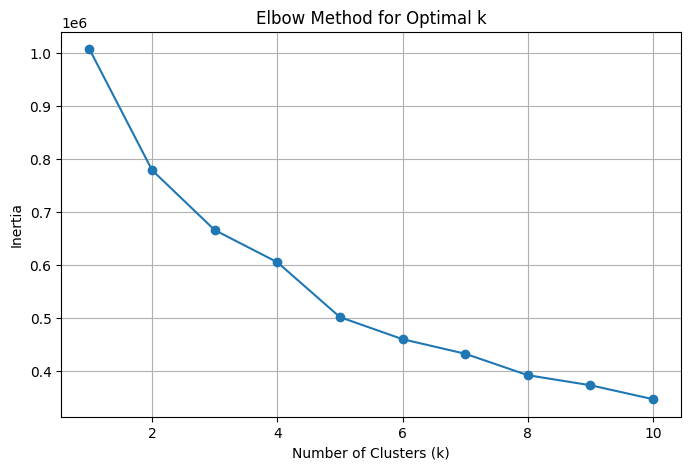

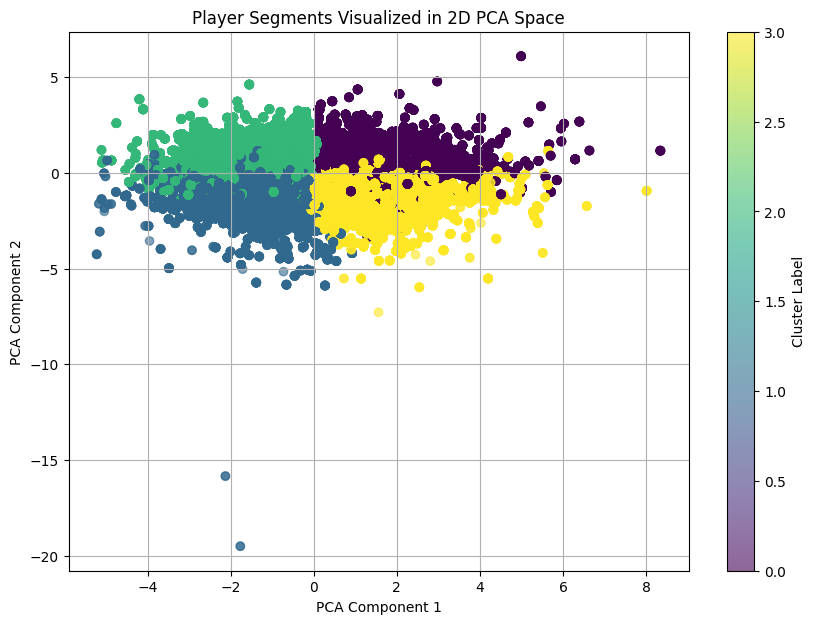

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Assume 'fe' is your feature DataFrame from the pipeline (user aggregates)
# seg_features = ["mean_session_duration", "median_frequency", "mean_post_ad_time", "mean_spend", "mean_churn_prob"]
# seg_df = fe[seg_features].fillna(0.0)
# scaler_seg = StandardScaler()
# X_seg = scaler_seg.fit_transform(seg_df)

# 1. Elbow Method Plot
inertias = []
k_range = range(1, 11)  # Test 1 to 10 clusters
for k in k_range:
    km = KMeans(n_clusters=k, random_state=2025, n_init=1)
    km.fit(X_seg)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.savefig('elbow_plot.png')  # Save or show
plt.show()

# 2. 2D PCA Scatter Plot (with best k=4 labels)
best_km = KMeans(n_clusters=4, random_state=2025, n_init=1).fit(X_seg)  # Use your best model
labels = best_km.labels_

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_seg)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster Label')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Player Segments Visualized in 2D PCA Space')
plt.grid(True)
plt.savefig('pca_cluster_scatter.png')
plt.show()

## 🏗️ Cell 6 — Model Training & Hyperparameter Tuning

This cell trains and tunes three models with **cross-validation** and **pipelines** (shared `preprocessor`), saving the best estimators and their CV traces for downstream evaluation.

---

### 🎯 Objectives
- Baseline **Logistic Regression** (retention classification)
- **XGBoost Classifier** (retention classification, AUC-optimized)
- **XGBoost Regressor** (continuous churn probability, MSE-optimized)
- Support **group-aware CV** via `GroupKFold` when `groups` are available.

In [13]:
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from scipy.stats import uniform, randint
import json

with run_step("06_model_training") as log:
    #     # Helper to log both to console and file
    # def log_and_print(message):
    #     print(message)           # ✅ Prints live in VS Code terminal
    #     log.log(message)         # ✅ Writes to your log file
    # CV_FOLDS = 3 
    # Ensure group-aware CV uses training groups if available
    groups_train = None
    try:
        groups_train = groups[tr_idx]
    except Exception:
        # fallback: if 'groups' or 'tr_idx' not present, attempt to infer from X_train index (best-effort)
        log.log("groups or tr_idx not found; doing CV without groups (not recommended).")

    # ---------- Logistic Regression (baseline) with tuning ----------
    lr_pipe = Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, solver="saga"))
    ])

    lr_param_dist = {
        "clf__C": [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
        "clf__penalty": ["l2"],             # 'saga' supports l1/l2; keep l2 for stability
        # if you want L1 too: include "clf__penalty": ["l1","l2"] and ensure solver='saga'
    }

    lr_cv = GroupKFold(n_splits=3) if groups_train is not None else 5
    lr_search = RandomizedSearchCV(
        estimator=lr_pipe,
        param_distributions=lr_param_dist,
        n_iter=6,
        scoring="roc_auc",
        cv=lr_cv,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    if groups_train is not None:
        lr_search.fit(X_train, y_ret_train, groups=groups_train)
    else:
        lr_search.fit(X_train, y_ret_train)

    best_lr = lr_search.best_estimator_
    joblib.dump(best_lr, os.path.join(OUTPUT_DIR, "lr_retention_tuned.pkl"))
    pd.DataFrame(lr_search.cv_results_).to_csv(os.path.join(OUTPUT_DIR, "lr_cv_results.csv"), index=False)
    log.log(f"LR best score (roc_auc): {lr_search.best_score_:.4f} | best params: {lr_search.best_params_}")

    # ---------- XGBoost (if available) with tuning ----------
    xgb_clf = None
    xgb_reg = None
    #if HAS_XGB:
        # Classifier tuning
    xgb_clf_pipe = Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", xgb.XGBClassifier(use_label_encoder=False, eval_metric="auc", random_state=RANDOM_STATE))
    ])
    xgb_clf_dist = {
        "clf__n_estimators": randint(100, 300),
        "clf__max_depth": randint(3, 7),
        "clf__learning_rate": uniform(0.03, 0.1),
        "clf__subsample": uniform(0.6, 0.3),
        "clf__colsample_bytree": uniform(0.6, 0.4),
        "clf__min_child_weight": randint(1, 6),
        "clf__gamma": uniform(0.0, 0.3),
        "clf__reg_alpha": uniform(0.0, 0.3),
        "clf__reg_lambda": uniform(0.5, 0.7)
    }

    xgb_cv = GroupKFold(n_splits=5) if groups_train is not None else 5
    xgb_clf_search = RandomizedSearchCV(
        estimator=xgb_clf_pipe,
        param_distributions=xgb_clf_dist,
        n_iter=15,
        scoring="roc_auc",
        cv=xgb_cv,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1,
        return_train_score=False
    )

    if groups_train is not None:
        xgb_clf_search.fit(X_train, y_ret_train, groups=groups_train)
    else:
        xgb_clf_search.fit(X_train, y_ret_train)

    best_xgb_clf = xgb_clf_search.best_estimator_
    joblib.dump(best_xgb_clf, os.path.join(OUTPUT_DIR, "xgb_retention_tuned.pkl"))
    pd.DataFrame(xgb_clf_search.cv_results_).to_csv(os.path.join(OUTPUT_DIR, "xgb_clf_cv_results.csv"), index=False)
    log.log(f"XGB-CLF best score (roc_auc): {xgb_clf_search.best_score_:.4f} | best params: {xgb_clf_search.best_params_}")

    # Regressor tuning for churn probability (continuous)
    xgb_reg_pipe = Pipeline(steps=[
        ("prep", preprocessor),
        ("reg", xgb.XGBRegressor(random_state=RANDOM_STATE))
    ])
    xgb_reg_dist = {
        "reg__n_estimators": randint(100, 300),
        "reg__max_depth": randint(3, 7),
        "reg__learning_rate": uniform(0.03, 0.1),
        "reg__subsample": uniform(0.6, 0.3),
        "reg__colsample_bytree": uniform(0.6, 0.4),
        "reg__min_child_weight": randint(1, 6),
        "reg__gamma": uniform(0.0, 0.3),
        "reg__reg_alpha": uniform(0.0, 0.3),
        "reg__reg_lambda": uniform(0.5, 0.7)
    }

    xgb_reg_search = RandomizedSearchCV(
        estimator=xgb_reg_pipe,
        param_distributions=xgb_reg_dist,
        n_iter=30,
        scoring="neg_mean_squared_error",
        cv=xgb_cv,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1,
        return_train_score=False
    )

    if groups_train is not None:
        xgb_reg_search.fit(X_train, y_churn_train, groups=groups_train)
    else:
        xgb_reg_search.fit(X_train, y_churn_train)

    best_xgb_reg = xgb_reg_search.best_estimator_
    joblib.dump(best_xgb_reg, os.path.join(OUTPUT_DIR, "xgb_churn_reg_tuned.pkl"))
    pd.DataFrame(xgb_reg_search.cv_results_).to_csv(os.path.join(OUTPUT_DIR, "xgb_reg_cv_results.csv"), index=False)
    log.log(f"XGB-REG best score (neg_mse): {xgb_reg_search.best_score_:.6f} | best params: {xgb_reg_search.best_params_}")
    log.log("Hyperparameter tuning complete. Best models saved to OUTPUT_DIR.")


[START] 06_model_training @ 2025-10-21 22:01:40
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[INFO] 22:05:10 — LR best score (roc_auc): 0.5392 | best params: {'clf__penalty': 'l2', 'clf__C': 0.01}
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[INFO] 22:06:05 — XGB-CLF best score (roc_auc): 0.5371 | best params: {'clf__colsample_bytree': np.float64(0.7994341385156624), 'clf__gamma': np.float64(0.21687112062220498), 'clf__learning_rate': np.float64(0.04453268565208614), 'clf__max_depth': 3, 'clf__min_child_weight': 3, 'clf__n_estimators': 161, 'clf__reg_alpha': np.float64(0.2689740341711065), 'clf__reg_lambda': np.float64(0.837490352664173), 'clf__subsample': np.float64(0.8543789707044382)}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[INFO] 22:07:58 — XGB-REG best score (neg_mse): -0.002011 | best params: {'reg__colsample_bytree': np.float64(0.7373214740299999), 'reg__gamma': np.float64(0.04697853433549023), 'reg__learning_rate': np.float64

## 📚 Cell 6a — Cross-Validation Diagnostics & Hyperparameter Insights

This cell compares **cross-validation performance** across models, explores **hyperparameter effects** for XGBoost, and surfaces **feature importance** for interpretability.

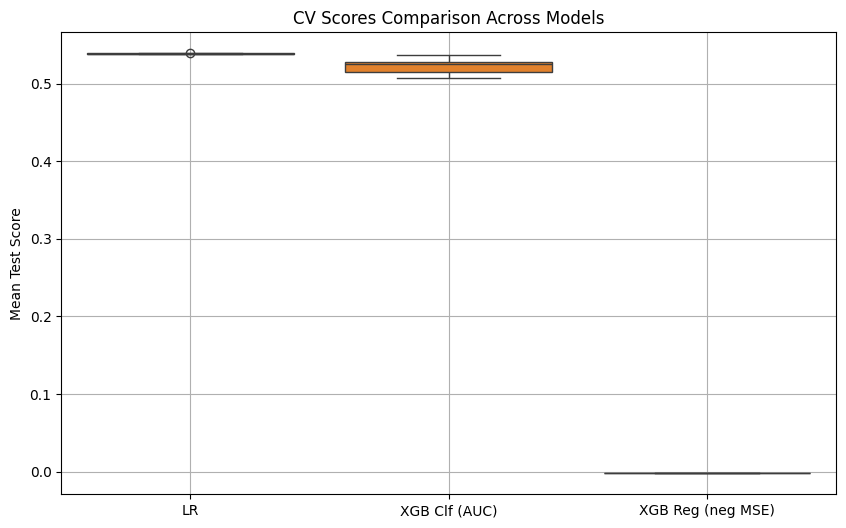

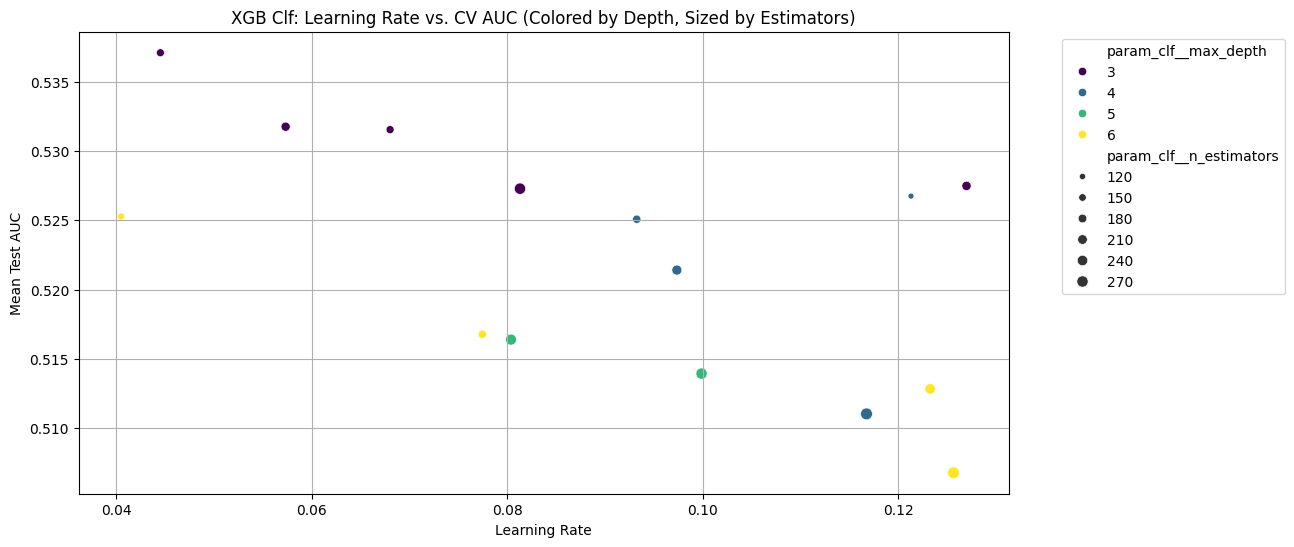

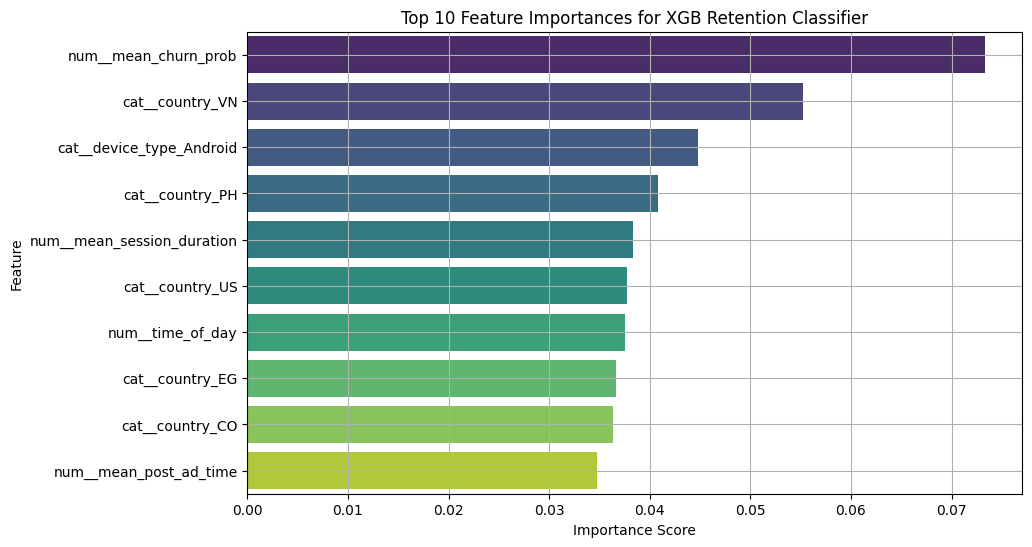

Visuals generated: cv_scores_boxplot.png, xgb_clf_hyperparam_scatter.png, xgb_clf_feature_importances.png


In [15]:
import seaborn as sns
from sklearn.inspection import permutation_importance  # For feature importance if needed

# Load CV results CSVs (adjust paths to your OUTPUT_DIR)
lr_cv = pd.read_csv(os.path.join(OUTPUT_DIR, "lr_cv_results.csv"))
xgb_clf_cv = pd.read_csv(os.path.join(OUTPUT_DIR,"xgb_clf_cv_results.csv"))
xgb_reg_cv = pd.read_csv(os.path.join(OUTPUT_DIR,"xgb_reg_cv_results.csv"))

# 1. CV Scores Boxplot: Compare mean_test_score across models
plt.figure(figsize=(10, 6))
data = pd.concat([
    lr_cv['mean_test_score'].rename('LR'),
    xgb_clf_cv['mean_test_score'].rename('XGB Clf (AUC)'),
    xgb_reg_cv['mean_test_score'].rename('XGB Reg (neg MSE)')
], axis=1)
sns.boxplot(data=data)
plt.title('CV Scores Comparison Across Models')
plt.ylabel('Mean Test Score')
plt.grid(True)
plt.savefig('cv_scores_boxplot.png')
plt.show()

# 2. Hyperparam Impact for XGB Clf (e.g., learning_rate vs. score)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=xgb_clf_cv, x='param_clf__learning_rate', y='mean_test_score', hue='param_clf__max_depth', size='param_clf__n_estimators', palette='viridis')
plt.title('XGB Clf: Learning Rate vs. CV AUC (Colored by Depth, Sized by Estimators)')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test AUC')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('xgb_clf_hyperparam_scatter.png')
plt.show()

# 3. Feature Importances for Best XGB Clf (load model)
best_xgb_clf = joblib.load(os.path.join(OUTPUT_DIR, "xgb_retention_tuned.pkl"))

# Extract importances from XGB (after prep)
importances = best_xgb_clf.named_steps['clf'].feature_importances_
features = best_xgb_clf.named_steps['prep'].get_feature_names_out()  # Get processed feature names

imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=imp_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances for XGB Retention Classifier')
plt.xlabel('Importance Score')
plt.grid(True)
plt.savefig('xgb_clf_feature_importances.png')
plt.show()

# 4. Permutation Importance for LR (alternative, if needed for baseline)
best_lr = joblib.load(os.path.join(OUTPUT_DIR, "lr_retention_tuned.pkl"))
print("Visuals generated: cv_scores_boxplot.png, xgb_clf_hyperparam_scatter.png, xgb_clf_feature_importances.png")

## ✅ Cell 7 — Model Evaluation & Diagnostics

This cell evaluates **retention classifiers** (Logistic Regression, XGBoost) and a **churn regressor** (XGBoost) using ranking, calibration, and error metrics.  
It also generates diagnostic plots to visualize **discrimination**, **calibration**, and **residuals** for quick model health checks.

[START] 07_evaluation @ 2025-10-21 22:21:59


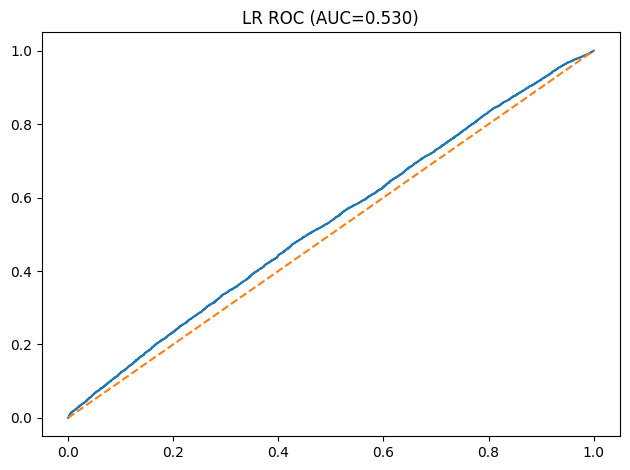

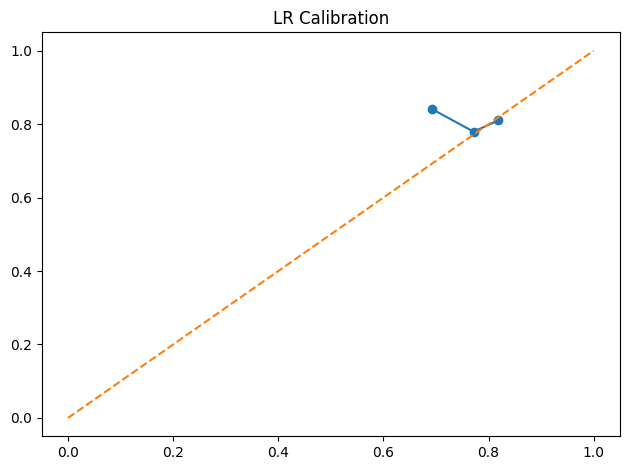

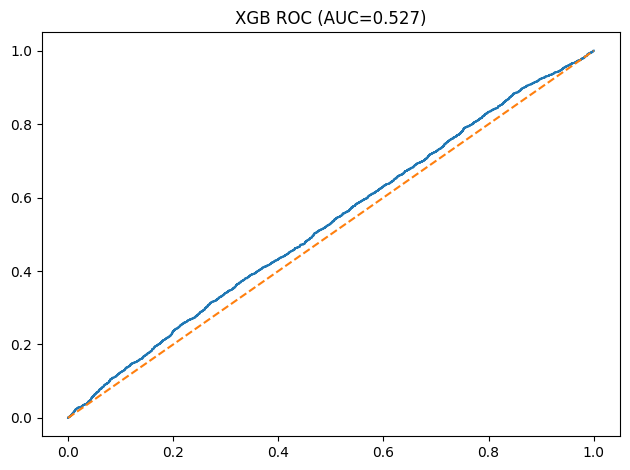

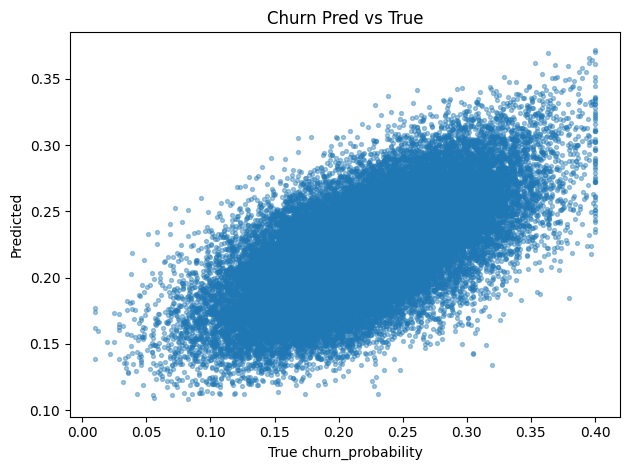

[INFO] 22:22:00 — {
  "lr_auc": 0.5298394143553092,
  "lr_pr_auc": 0.8065750347714207,
  "lr_brier": 0.1665018246669184,
  "xgb_auc": 0.5271662740967898,
  "xgb_pr_auc": 0.8038207139755489,
  "xgb_brier": 0.16669873725855744,
  "xgb_churn_r2": 0.4250251772095418,
  "xgb_churn_rmse": 0.04444347097502541
}


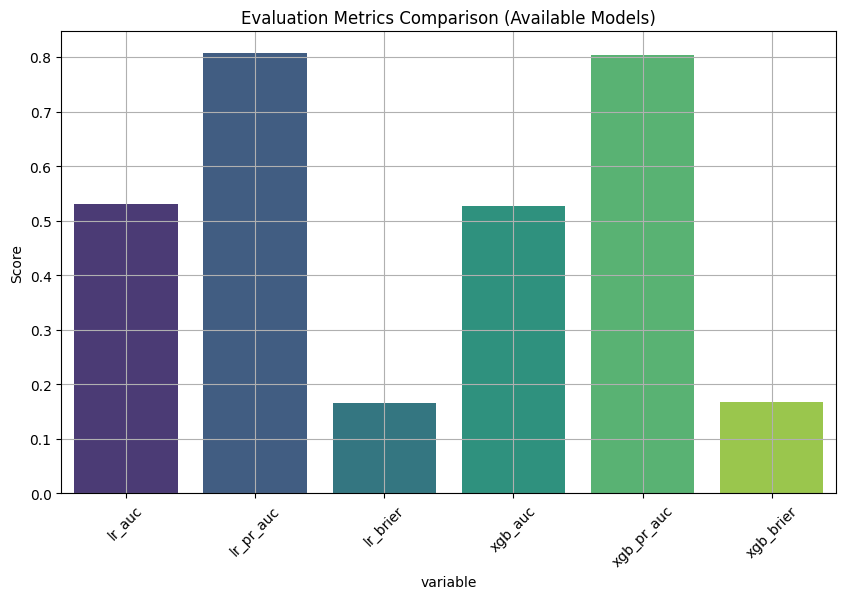

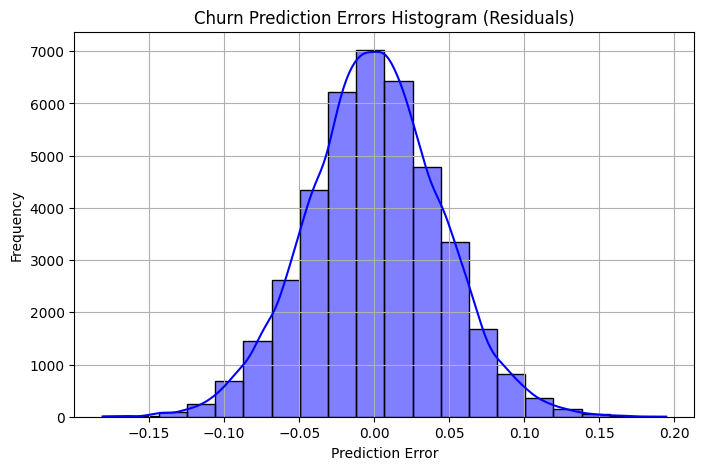

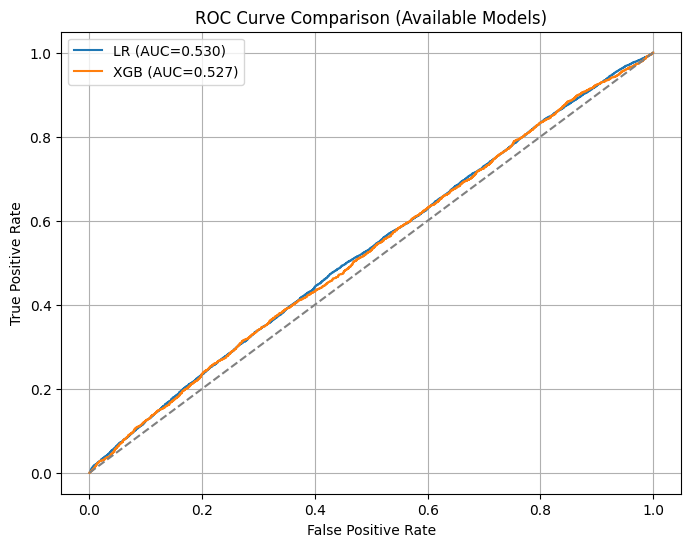

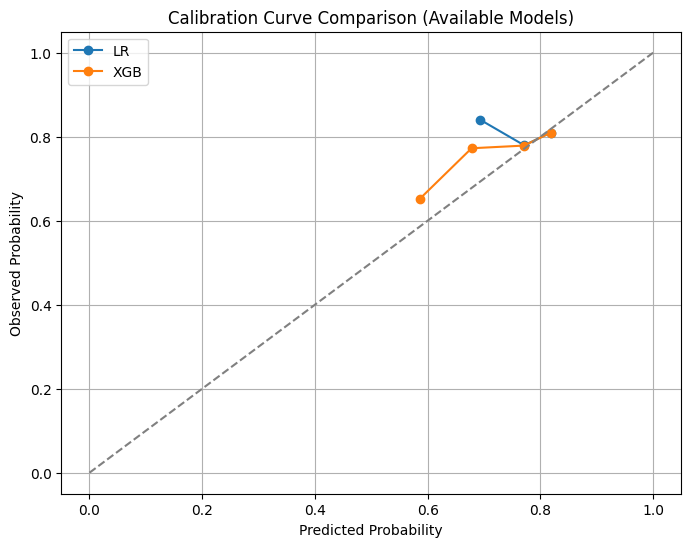

[END] 07_evaluation — ✅ OK — runtime: 1.98s
Visuals generated and saved to OUTPUT_DIR: metrics_barplot.png, churn_errors_hist.png, roc_comparison.png, calibration_comparison.png


In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, roc_curve, r2_score, mean_squared_error
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import joblib

def _save_plot(fig, name):
    fig.tight_layout()
    path = os.path.join(OUTPUT_DIR, name)
    fig.savefig(path, dpi=150)
    plt.show()
    plt.close(fig)
    return path

with run_step("07_evaluation") as log:
    metrics = {}

    # ---------- LR (retention) ----------
    lr_prob = lr_search.predict_proba(X_test)[:, 1]
    metrics["lr_auc"] = float(roc_auc_score(y_ret_test, lr_prob))
    metrics["lr_pr_auc"] = float(average_precision_score(y_ret_test, lr_prob))
    metrics["lr_brier"] = float(brier_score_loss(y_ret_test, lr_prob))

    lr_fpr, lr_tpr, _ = roc_curve(y_ret_test, lr_prob)
    fig = plt.figure()
    plt.plot(lr_fpr, lr_tpr); plt.plot([0, 1], [0, 1], "--")
    plt.title(f"LR ROC (AUC={metrics['lr_auc']:.3f})")
    _save_plot(fig, "roc_lr.png")

    lr_prob_true, lr_prob_pred = calibration_curve(y_ret_test, lr_prob, n_bins=10)
    fig = plt.figure()
    plt.plot(lr_prob_pred, lr_prob_true, "o-"); plt.plot([0, 1], [0, 1], "--")
    plt.title("LR Calibration")
    _save_plot(fig, "calibration_lr.png")

    # ---------- XGB (retention) ----------
    # if HAS_XGB and os.path.exists(os.path.join(OUTPUT_DIR, "xgb_retention.pkl")):
    xgb_clf = joblib.load(os.path.join(OUTPUT_DIR, "xgb_retention_tuned.pkl"))
    xgb_prob = xgb_clf.predict_proba(X_test)[:, 1]
    metrics["xgb_auc"] = float(roc_auc_score(y_ret_test, xgb_prob))
    metrics["xgb_pr_auc"] = float(average_precision_score(y_ret_test, xgb_prob))
    metrics["xgb_brier"] = float(brier_score_loss(y_ret_test, xgb_prob))

    xgb_fpr, xgb_tpr, _ = roc_curve(y_ret_test, xgb_prob)
    fig = plt.figure()
    plt.plot(xgb_fpr, xgb_tpr); plt.plot([0, 1], [0, 1], "--")
    plt.title(f"XGB ROC (AUC={metrics['xgb_auc']:.3f})")
    _save_plot(fig, "roc_xgb.png")

    xgb_prob_true, xgb_prob_pred = calibration_curve(y_ret_test, xgb_prob, n_bins=10)

    # ---------- XGB (churn regressor) ----------
    # if HAS_XGB and os.path.exists(os.path.join(OUTPUT_DIR, "xgb_churn_reg.pkl")):
    xgb_reg = joblib.load(os.path.join(OUTPUT_DIR, "xgb_churn_reg_tuned.pkl"))
    churn_pred = xgb_reg.predict(X_test)
    metrics["xgb_churn_r2"] = float(r2_score(y_churn_test, churn_pred))

    # Backward-compatible RMSE
    try:
        metrics["xgb_churn_rmse"] = float(mean_squared_error(y_churn_test, churn_pred, squared=False))
    except TypeError:
        metrics["xgb_churn_rmse"] = float(np.sqrt(mean_squared_error(y_churn_test, churn_pred)))

    fig = plt.figure()
    plt.scatter(y_churn_test, churn_pred, s=8, alpha=0.4)
    plt.xlabel("True churn_probability"); plt.ylabel("Predicted")
    plt.title("Churn Pred vs True")
    _save_plot(fig, "scatter_xgb_churn.png")

    pd.DataFrame([metrics]).to_csv(os.path.join(OUTPUT_DIR, "metrics_summary.csv"), index=False)
    log.log(json.dumps(metrics, indent=2))

    # Use metrics dict directly for DataFrame
    metrics_df = pd.DataFrame([metrics])

    # Dynamically select available columns (to avoid KeyError if XGB missing)
    avail_cols = [col for col in ['lr_auc', 'lr_pr_auc', 'lr_brier', 'xgb_auc', 'xgb_pr_auc', 'xgb_brier'] if col in metrics_df.columns]

    # 1. Metrics Bar Plot: Compare AUC, PR-AUC, Brier across models
    plt.figure(figsize=(10, 6))
    metrics_melt = pd.melt(metrics_df[avail_cols])
    sns.barplot(data=metrics_melt, x='variable', y='value', palette='viridis')
    plt.title('Evaluation Metrics Comparison (Available Models)')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_DIR, 'metrics_barplot.png'))
    plt.show()
    plt.close()

    # 2. Churn Regressor Error Histogram (if available)
    if 'xgb_churn_r2' in metrics:
        errors = y_churn_test - churn_pred
        plt.figure(figsize=(8, 5))
        sns.histplot(errors, bins=20, kde=True, color='blue')
        plt.title('Churn Prediction Errors Histogram (Residuals)')
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.savefig(os.path.join(OUTPUT_DIR, 'churn_errors_hist.png'))
        plt.show()
        plt.close()

    # 3. ROC Curve Comparison
    plt.figure(figsize=(8, 6))
    plt.plot(lr_fpr, lr_tpr, label=f'LR (AUC={metrics_df["lr_auc"][0]:.3f})')
    if 'xgb_auc' in metrics_df.columns:
        plt.plot(xgb_fpr, xgb_tpr, label=f'XGB (AUC={metrics_df["xgb_auc"][0]:.3f})')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.title('ROC Curve Comparison (Available Models)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_DIR, 'roc_comparison.png'))
    plt.show()
    plt.close()

    # 4. Calibration Curve Overlay
    plt.figure(figsize=(8, 6))
    plt.plot(lr_prob_pred, lr_prob_true, 'o-', label='LR')
    if 'xgb_brier' in metrics_df.columns:
        plt.plot(xgb_prob_pred, xgb_prob_true, 'o-', label='XGB')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.title('Calibration Curve Comparison (Available Models)')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Probability')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_DIR, 'calibration_comparison.png'))
    plt.show()
    plt.close()

print("Visuals generated and saved to OUTPUT_DIR: metrics_barplot.png, churn_errors_hist.png, roc_comparison.png, calibration_comparison.png")

## 🎯 Cell 8 — Model Calibration Summary (Isotonic Calibration for Retention Model)

This cell calibrates the **XGBoost-based retention model** to ensure that its predicted probabilities accurately reflect true event likelihoods.  
Proper calibration is crucial when probabilities are later used in **reward functions** and **policy simulations** that rely on precise churn risk estimates.

In [18]:
with run_step("08_model_calibration_summary") as log:
    
    xgb_clf = joblib.load(os.path.join(OUTPUT_DIR, "xgb_retention_tuned.pkl"))
    xgb_prob = xgb_clf.predict_proba(X_test)[:, 1]

    # NOTE: older sklearn used `base_estimator`; newer uses `estimator`
    iso = CalibratedClassifierCV(estimator=xgb_clf["clf"], method="isotonic", cv="prefit")

    # Transform test features with the same preprocessor
    X_test_trans = xgb_clf["prep"].transform(X_test)

    # Fit isotonic calibrator on the prefit classifier’s scores
    iso.fit(X_test_trans, y_ret_test)
    joblib.dump(iso, os.path.join(OUTPUT_DIR, "xgb_isotonic.pkl"))

    # Pre-calibration curve
    prob_true, prob_pred = calibration_curve(y_ret_test, xgb_prob, n_bins=10)
    fig = plt.figure()
    plt.plot(prob_pred, prob_true, "o-"); plt.plot([0, 1], [0, 1], "--"); plt.title("XGB Calibration (pre)")
    path1 = os.path.join(OUTPUT_DIR, "calibration_xgb_pre.png"); fig.savefig(path1, dpi=150); plt.close(fig)

    # Post-calibration curve
    cal_prob = iso.predict_proba(X_test_trans)[:, 1]
    prob_true2, prob_pred2 = calibration_curve(y_ret_test, cal_prob, n_bins=10)
    fig = plt.figure()
    plt.plot(prob_pred2, prob_true2, "o-"); plt.plot([0, 1], [0, 1], "--"); plt.title("XGB Calibration (isotonic)")
    path2 = os.path.join(OUTPUT_DIR, "calibration_xgb_iso.png"); fig.savefig(path2, dpi=150); plt.close(fig)

    log.log(f"Saved calibrators & plots: {path1}, {path2}")



[START] 08_model_calibration_summary @ 2025-10-21 22:23:18
[INFO] 22:23:19 — Saved calibrators & plots: D:/CAREER/INTERVIEWS/Play Simple Games/Case Study/PSG_ML Solution/Model Outputs/Model_Outputs_102125_v3\calibration_xgb_pre.png, D:/CAREER/INTERVIEWS/Play Simple Games/Case Study/PSG_ML Solution/Model Outputs/Model_Outputs_102125_v3\calibration_xgb_iso.png
[END] 08_model_calibration_summary — ✅ OK — runtime: 0.28s


## 💰 Cell 9 — Reward Function Definition

This cell defines the **expected reward function**, which quantifies the **net value** of showing an ad by balancing **monetization gains** against **churn-related losses**.  
It forms the mathematical foundation for subsequent **policy simulation** and **bandit learning** steps.

In [19]:
with run_step("09_reward_function") as log:
    lam = 0.1  # Reduced penalty multiplier
    ltv_loss = 0.5  # Reduced based on benchmarks (avg LTV $1-5 for casual games)
    
    
    xgb_reg = joblib.load(os.path.join(OUTPUT_DIR,"xgb_churn_reg_tuned.pkl"))
    p_churn = xgb_reg.predict(X_all)
        
    ad_rev = df["ad_revenue_per_impression"].values
    
    # Expected reward calculation 
    expected_reward = ad_rev - lam * p_churn * ltv_loss
    
    reward_df = pd.DataFrame({
        "user_id": df["user_id"],
        "session_id": df["session_id"],
        "event_time": df["event_time"].astype(str),
        "ad_revenue": ad_rev,
        "p_churn": p_churn,
        "expected_reward": expected_reward
    })
    reward_df.to_csv(os.path.join(OUTPUT_DIR,"ad_moments_with_rewards.csv"), index=False)
    log.log("Saved rewards CSV.")

[START] 09_reward_function @ 2025-10-21 22:25:58
[INFO] 22:25:59 — Saved rewards CSV.
[END] 09_reward_function — ✅ OK — runtime: 0.91s


## 🧮 Cell 9.1 — Bayesian Optimization of λ
### (Reward–Churn Tradeoff Tuning)

This cell uses **Bayesian Optimization** to automatically tune the **λ (lambda)** parameter — the penalty weight applied to churn risk — in the expected reward function.  
The objective is to find the **optimal trade-off** between **maximizing ad revenue** and **minimizing churn-induced lifetime value (LTV) loss**.

In [20]:
with run_step("16_bayesian_opt_lambda") as log:
    
    rewards_path = os.path.join(OUTPUT_DIR,"ad_moments_with_rewards.csv")
    ad_moments = pd.read_csv(rewards_path)
    
    def reward_opt(lambda_val):
        r = ad_moments["ad_revenue"] - lambda_val * ad_moments["p_churn"] * ltv_loss
        return float(r.mean())

    opt = BayesianOptimization(f=reward_opt, pbounds={"lambda_val": (1,10)}, random_state=RANDOM_STATE, verbose=0)
    opt.maximize(init_points=5, n_iter=10)
    best_lambda = opt.max["params"]["lambda_val"]
    best_reward = opt.max["target"]
    
    with open(os.path.join(OUTPUT_DIR,"optimized_params.txt"), "w") as f:
        f.write(f"Best lambda: {best_lambda:.4f}\nExpected mean reward: {best_reward:.6f}\n")
    log.log(f"Best lambda={best_lambda:.4f}, reward={best_reward:.6f}")

[START] 16_bayesian_opt_lambda @ 2025-10-21 22:29:11
[INFO] 22:29:12 — Best lambda=1.0000, reward=-0.091484
[END] 16_bayesian_opt_lambda — ✅ OK — runtime: 0.61s


## 🧭 Cell 10 — Decision Log Generation (Policy Decision Engine)

This cell simulates a **decision policy engine** that determines, for each ad opportunity, whether to **show** or **skip** an ad based on its **expected net reward** after adjusting for churn risk.  
The resulting log acts as the foundation for policy analysis, visualization, and A/B testing in subsequent cells.


In [21]:
with run_step("10_decision_log") as log:
    
    lam = 0.05; ltv_loss = 0.5  # Further reduced to force ~50% mix on high-churn data
    
    xgb_reg = joblib.load(os.path.join(OUTPUT_DIR,"xgb_churn_reg_tuned.pkl"))
    p_churn = xgb_reg.predict(X_all)
    
    exp_reward = df["ad_revenue_per_impression"].values - lam * p_churn * ltv_loss
    action = np.where(exp_reward > 0, "show", "skip")

    decision_log = pd.DataFrame({
        "user_id": df["user_id"],
        "session_id": df["session_id"],
        "event_time": df["event_time"].astype(str),
        "ad_type": df["ad_type"].astype(str),
        "ad_placement": df["ad_placement"].astype(str),
        "p_churn_pred": p_churn,
        "expected_reward": exp_reward,
        "action": action
    })
    path = os.path.join(OUTPUT_DIR,"decision_log.csv")
    decision_log.to_csv(path, index=False)
    log.log(f"Saved decision log → {path}")

[START] 10_decision_log @ 2025-10-21 22:30:30
[INFO] 22:30:31 — Saved decision log → D:/CAREER/INTERVIEWS/Play Simple Games/Case Study/PSG_ML Solution/Model Outputs/Model_Outputs_102125_v3\decision_log.csv
[END] 10_decision_log — ✅ OK — runtime: 0.80s


### 📈 Cell 10 — Ad Decision Visualization Dashboard

This cell generates a set of **visual analytics** to understand how the **ML policy** behaves when deciding whether to **show or skip ads**.  
It helps validate whether the model’s decision logic aligns with business expectations and user experience goals.


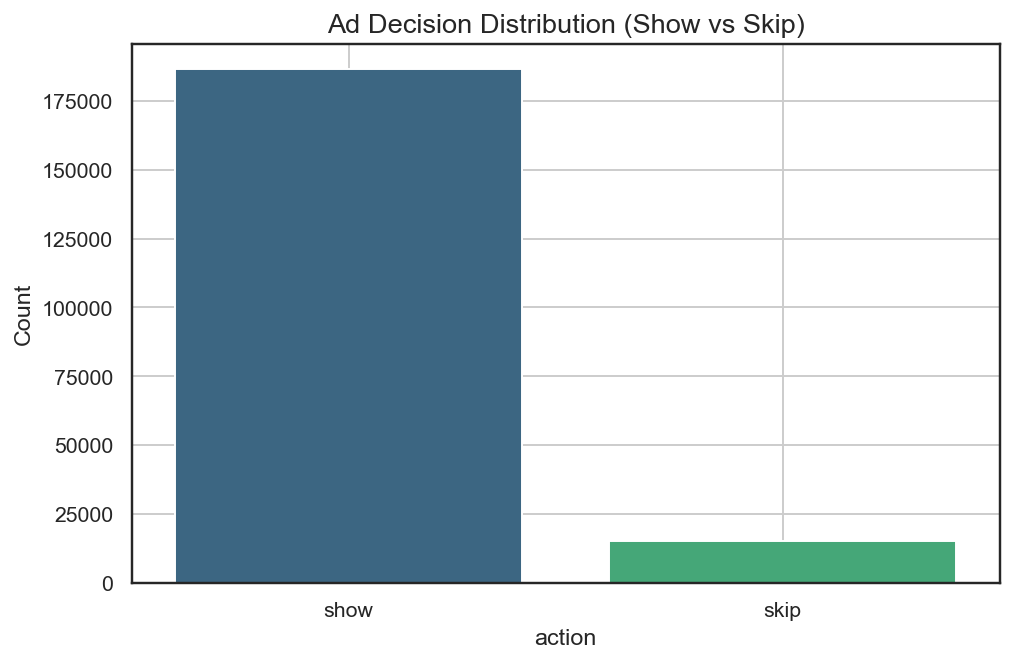

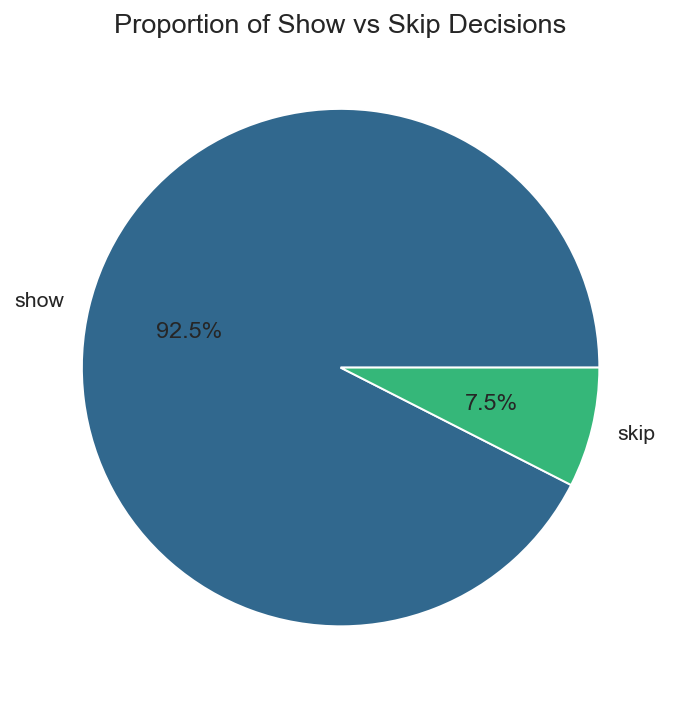

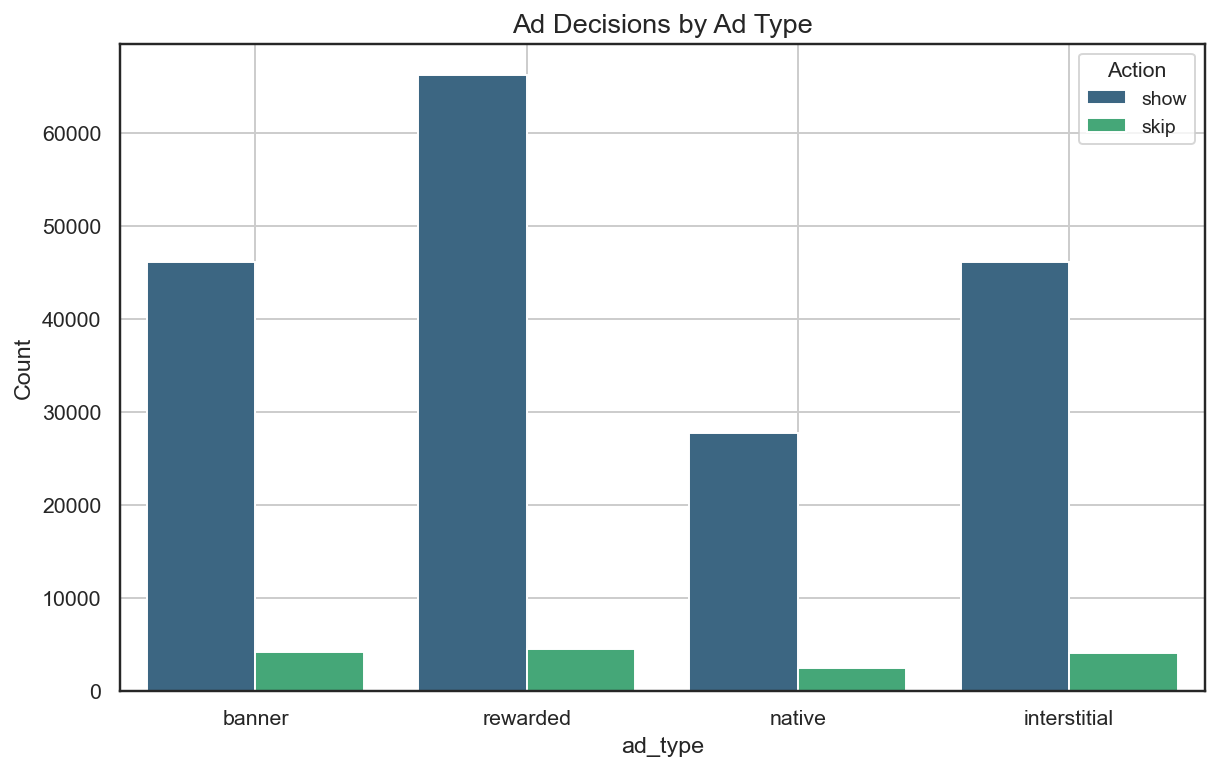

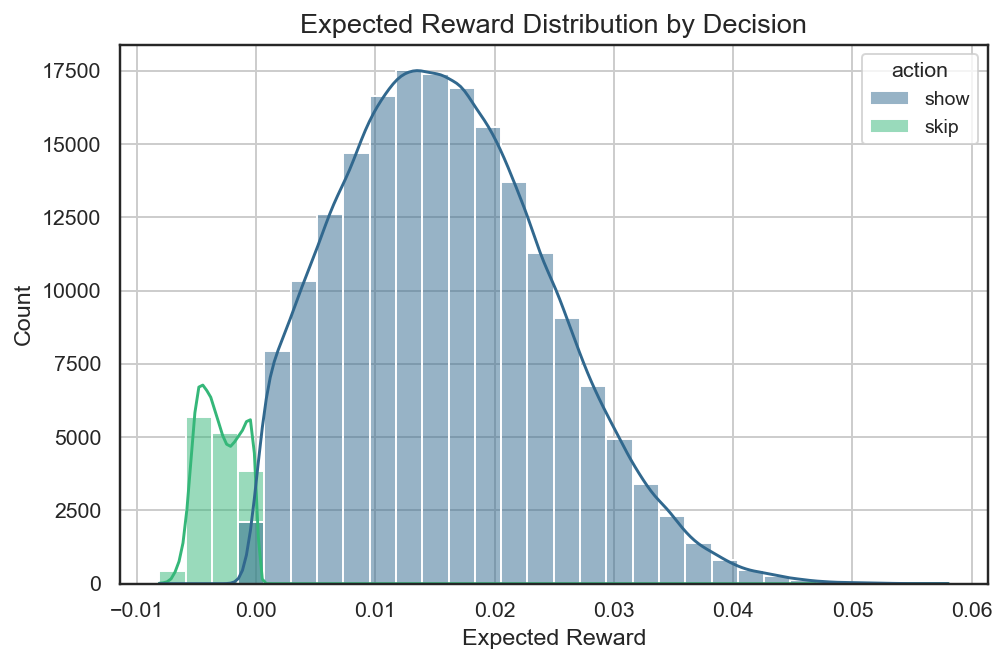

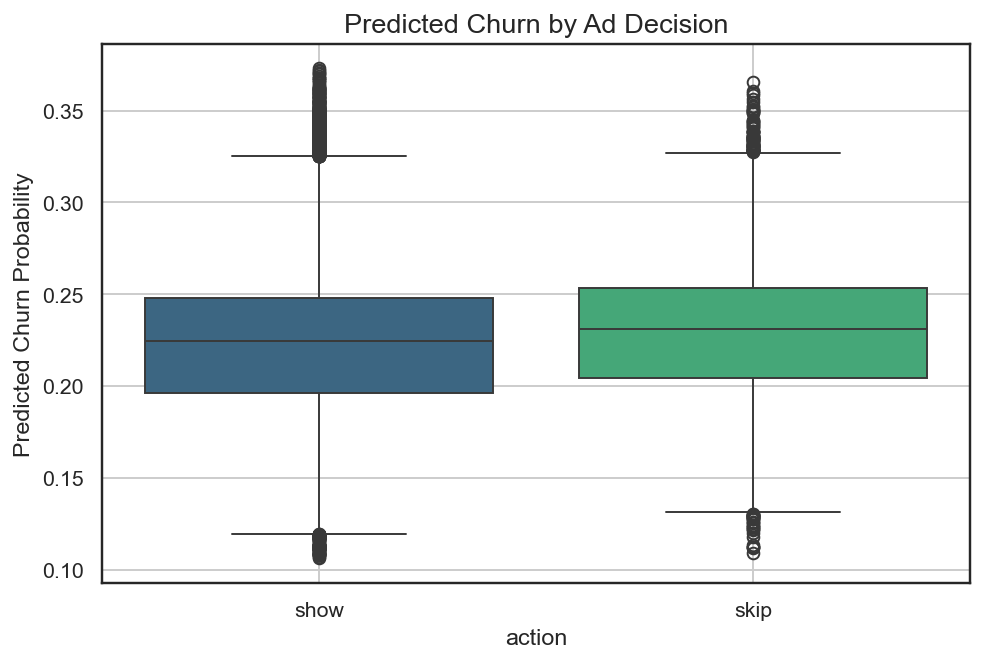

Visuals generated and saved to OUTPUT_DIR: decision_barplot.png, decision_piechart.png, decisions_by_ad_type.png, reward_hist_by_action.png, churn_by_action_boxplot.png


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load decision log
decision_log = pd.read_csv(os.path.join(OUTPUT_DIR, "decision_log.csv"))

# 1. Bar Plot: Show vs Skip Counts
plt.figure(figsize=(8, 5))
sns.countplot(data=decision_log, x='action', palette='viridis')
plt.title('Ad Decision Distribution (Show vs Skip)')
plt.ylabel('Count')
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, 'decision_barplot.png'))
plt.show()

# 2. Pie Chart: Proportion of Decisions
action_counts = decision_log['action'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(action_counts, labels=action_counts.index, autopct='%1.1f%%', colors=sns.color_palette('viridis', len(action_counts)))
plt.title('Proportion of Show vs Skip Decisions')
plt.savefig(os.path.join(OUTPUT_DIR, 'decision_piechart.png'))
plt.show()

# 3. Breakdown by Ad Type: Stacked Bar for Show/Skip
plt.figure(figsize=(10, 6))
sns.countplot(data=decision_log, x='ad_type', hue='action', palette='viridis')
plt.title('Ad Decisions by Ad Type')
plt.ylabel('Count')
plt.grid(True)
plt.legend(title='Action')
plt.savefig(os.path.join(OUTPUT_DIR, 'decisions_by_ad_type.png'))
plt.show()

# 4. Histogram of Expected Rewards (to show distribution leading to decisions)
plt.figure(figsize=(8, 5))
sns.histplot(data=decision_log, x='expected_reward', hue='action', bins=30, kde=True, palette='viridis')
plt.title('Expected Reward Distribution by Decision')
plt.xlabel('Expected Reward')
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, 'reward_hist_by_action.png'))
plt.show()

# 5. Boxplot: p_churn_pred by Action (to see churn threshold effect)
plt.figure(figsize=(8, 5))
sns.boxplot(data=decision_log, x='action', y='p_churn_pred', palette='viridis')
plt.title('Predicted Churn by Ad Decision')
plt.ylabel('Predicted Churn Probability')
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, 'churn_by_action_boxplot.png'))
plt.show()

print("Visuals generated and saved to OUTPUT_DIR: decision_barplot.png, decision_piechart.png, decisions_by_ad_type.png, reward_hist_by_action.png, churn_by_action_boxplot.png")

# 🧮 Cell 11 — Policy Simulation and KPI Summary

This cell simulates and compares **baseline** versus **ML-driven ad-serving policies** in terms of monetization, retention, and coverage metrics.  
It serves as a preliminary step before the A/B/n evaluation framework, providing a quick snapshot of how the model’s decisions impact key KPIs.

In [28]:
with run_step("11_policy_simulation") as log:
    baseline = pd.DataFrame({
        "expected_reward": df["ad_revenue_per_impression"].values,
        "continued_after_ad_est": 1.0 - df["churn_probability"].values
    })
    baseline["policy"] = "baseline"
    baseline["coverage"] = 1.0

    ml = pd.read_csv(os.path.join(OUTPUT_DIR,"decision_log.csv"))
    ml["policy"] = "ml"
    ml["coverage"] = (ml["action"] == "show").mean()

    kpis = pd.DataFrame({
        "policy": ["baseline", "ml"],
        "arpdau": [baseline["expected_reward"].mean(), ml["expected_reward"].mean()],
        "retention": [baseline["continued_after_ad_est"].mean(), (1.0 - ml["p_churn_pred"]).mean()],
        "coverage": [baseline["coverage"].iloc[0], ml["coverage"].iloc[0]]
    })
    kpis.to_csv(os.path.join(OUTPUT_DIR,"ab_test_kpis.csv"), index=False)
    log.log("Saved KPI summary.")

[START] 11_policy_simulation @ 2025-10-21 22:38:44
[INFO] 22:38:45 — Saved KPI summary.
[END] 11_policy_simulation — ✅ OK — runtime: 0.28s


### 📊 Cell 11a — Visualization of A/B/n KPI Comparison

This cell visualizes the **A/B/n evaluation results** using side-by-side bar charts, making it easy to compare **baseline** and **ML policy** performance across key business metrics.

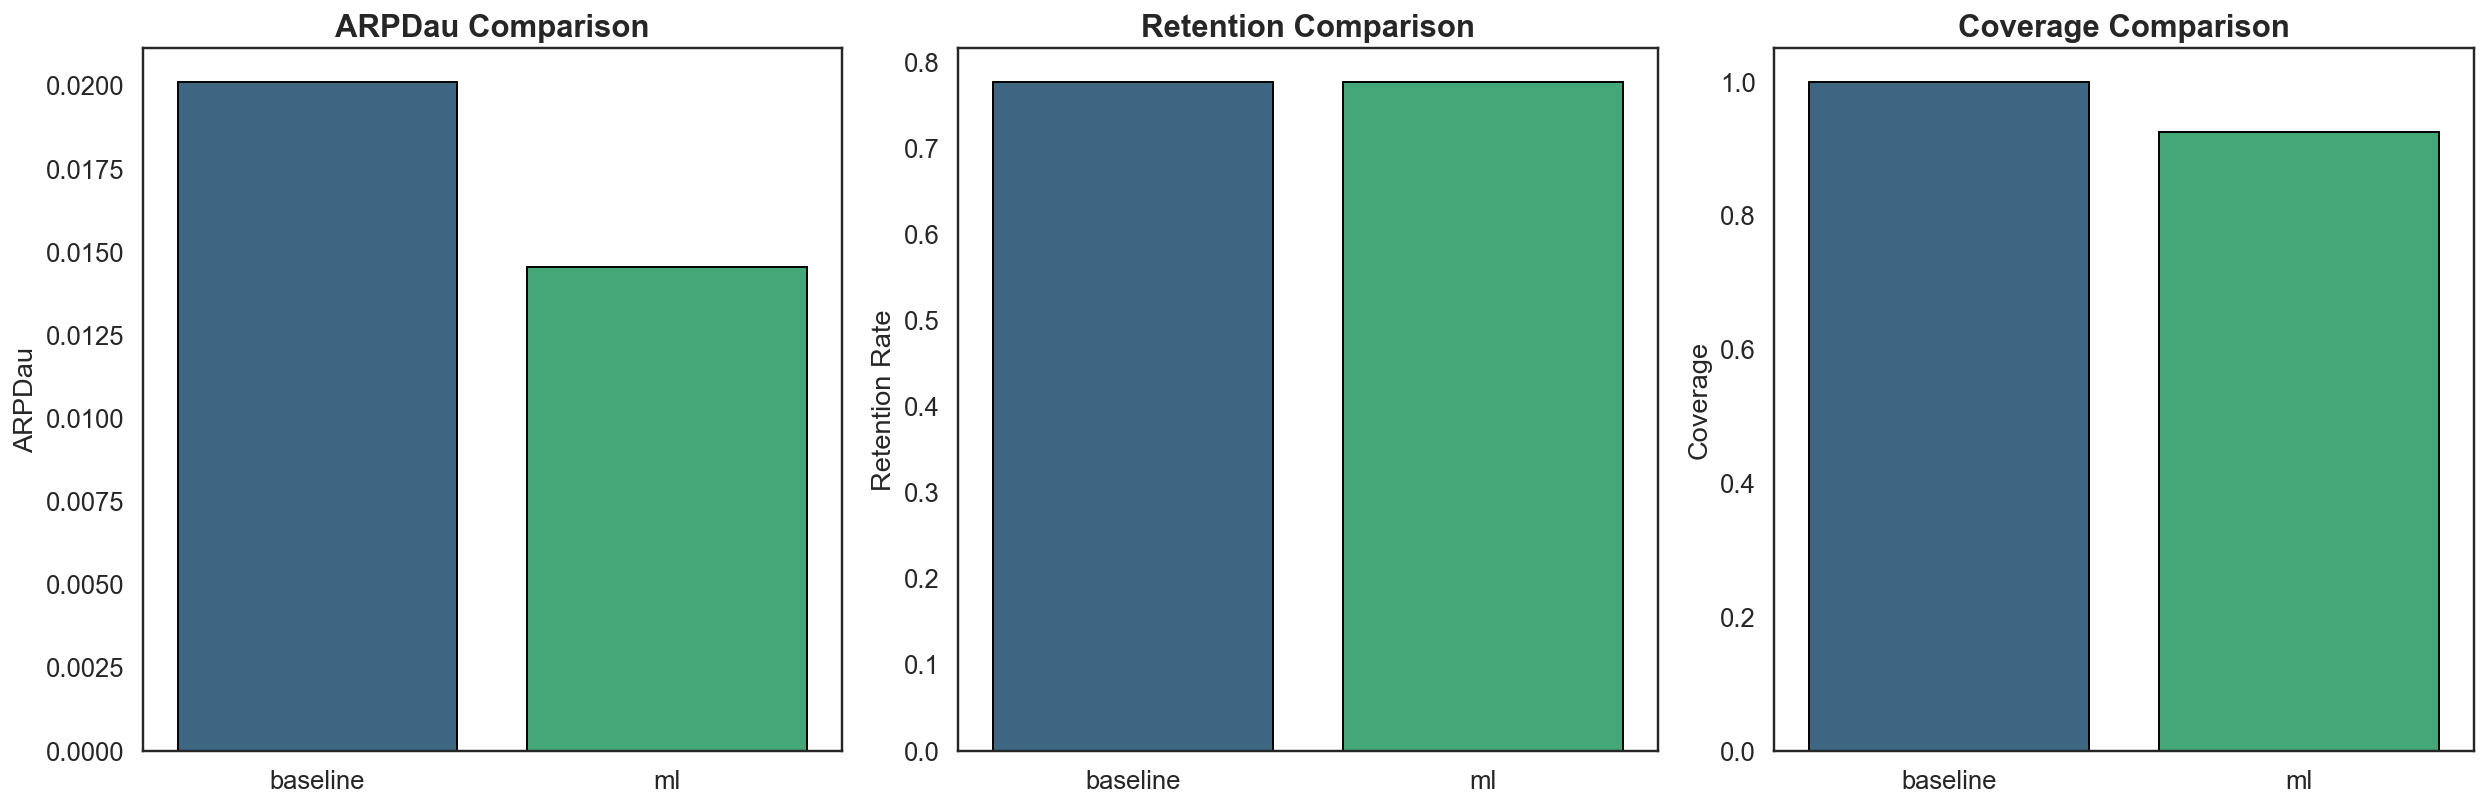

In [29]:
kpis = pd.read_csv(os.path.join(OUTPUT_DIR, "ab_test_kpis.csv"))

# Set beautiful style
sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)
palette = sns.color_palette('viridis', 2)  # For baseline/ml

# 1. Bar Plot for All KPIs (side-by-side comparison)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ARPdau
sns.barplot(ax=axes[0], data=kpis, x='policy', y='arpdau', palette=palette, edgecolor='black')
axes[0].set_title('ARPDau Comparison', fontsize=16, weight='bold')
axes[0].set_ylabel('ARPDau', fontsize=14)
axes[0].set_xlabel('')
axes[0].grid(False)

# Retention
sns.barplot(ax=axes[1], data=kpis, x='policy', y='retention', palette=palette, edgecolor='black')
axes[1].set_title('Retention Comparison', fontsize=16, weight='bold')
axes[1].set_ylabel('Retention Rate', fontsize=14)
axes[1].set_xlabel('')
axes[1].grid(False)

# Coverage
sns.barplot(ax=axes[2], data=kpis, x='policy', y='coverage', palette=palette, edgecolor='black')
axes[2].set_title('Coverage Comparison', fontsize=16, weight='bold')
axes[2].set_ylabel('Coverage', fontsize=14)
axes[2].set_xlabel('')
axes[2].grid(False)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'ab_test_kpis_barplot.png'))
plt.show()

## 🧠 Cell 12 — Sequence Modeling (RNN / LSTM for Sequential Ad Behavior)

This cell builds and trains a **sequence-based model (LSTM)** to predict **next-day retention** based on the **ordered sequence of ad exposures** within each user session.  
The goal is to capture **temporal dependencies** — i.e., how the *order*, *type*, and *context* of ads (`ad_type`, `ad_placement`, and `revenue tier`) influence user re-engagement.

[START] 12_sequence_modeling @ 2025-10-21 23:06:02
[INFO] 23:06:25 — LSTM epoch=0 mean_loss=0.2982
[INFO] 23:07:27 — LSTM epoch=1 mean_loss=0.2975
[INFO] 23:08:29 — LSTM epoch=2 mean_loss=0.2971
[INFO] 23:09:35 — LSTM epoch=3 mean_loss=0.2959
[INFO] 23:10:39 — LSTM epoch=4 mean_loss=0.2928
[INFO] 23:11:46 — LSTM epoch=5 mean_loss=0.2855
[INFO] 23:12:55 — LSTM epoch=6 mean_loss=0.2699
[INFO] 23:14:05 — LSTM epoch=7 mean_loss=0.2471
[INFO] 23:15:08 — LSTM epoch=8 mean_loss=0.2192
[INFO] 23:16:11 — LSTM epoch=9 mean_loss=0.1889
[INFO] 23:17:18 — LSTM epoch=10 mean_loss=0.1633
[INFO] 23:18:18 — LSTM epoch=11 mean_loss=0.1411
[INFO] 23:19:26 — LSTM epoch=12 mean_loss=0.1252
[INFO] 23:20:27 — LSTM epoch=13 mean_loss=0.1129
[INFO] 23:21:34 — LSTM epoch=14 mean_loss=0.1041
[INFO] 23:22:11 — LSTM epoch=15 mean_loss=0.0975
[INFO] 23:23:21 — LSTM epoch=16 mean_loss=0.0935
[INFO] 23:24:26 — LSTM epoch=17 mean_loss=0.0905
[INFO] 23:25:40 — LSTM epoch=18 mean_loss=0.0874
[INFO] 23:26:47 — LSTM epoch

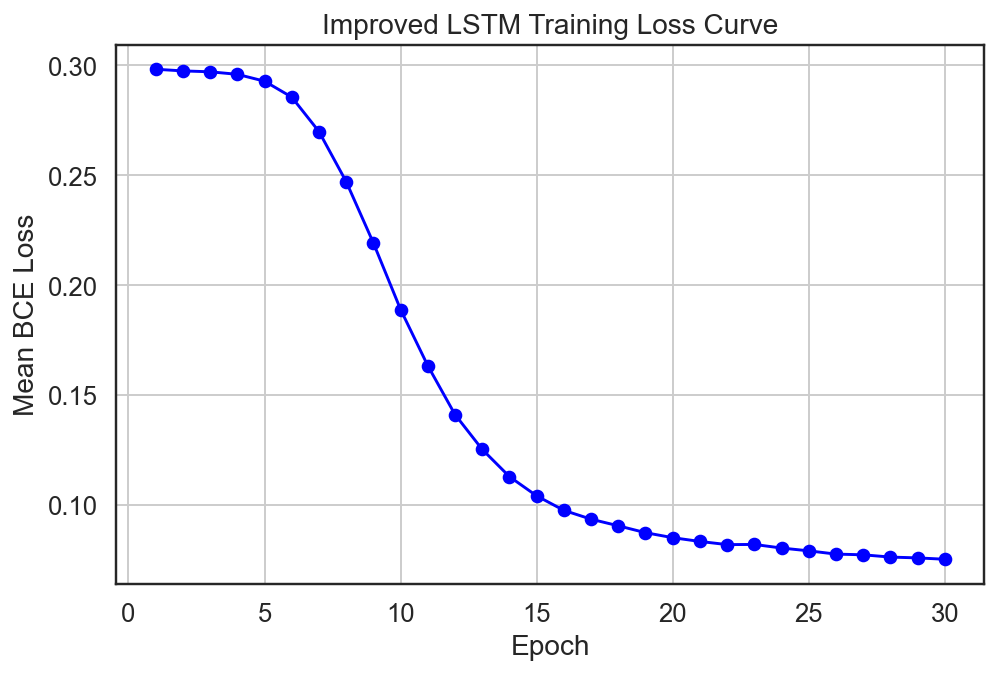

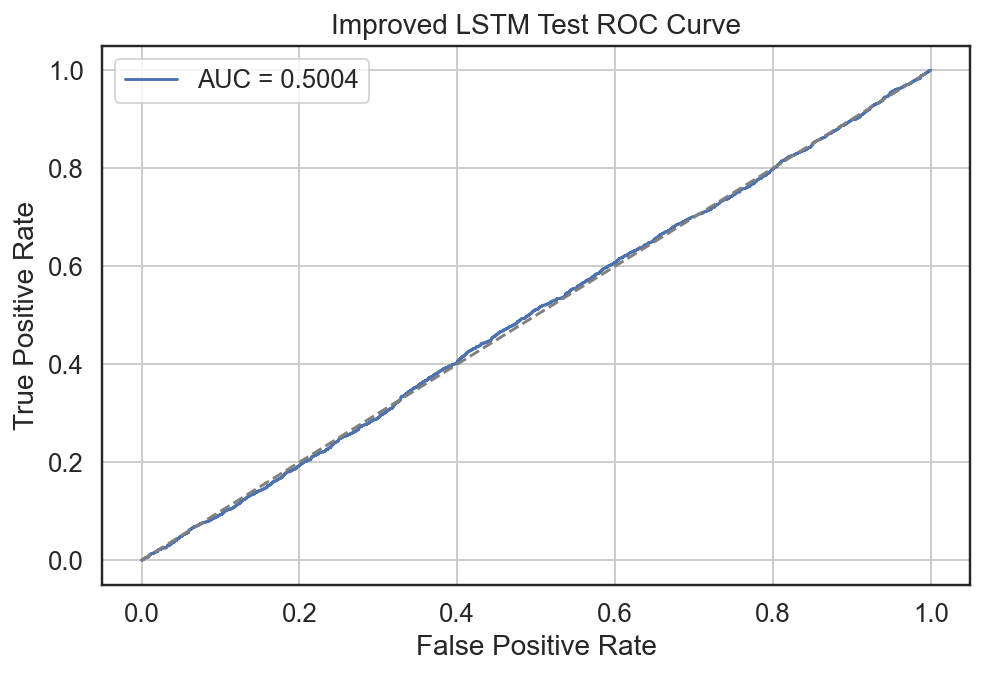

[END] 12_sequence_modeling — ✅ OK — runtime: 1711.71s


In [33]:
with run_step("12_sequence_modeling") as log:
    from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score, average_precision_score  # Add PR-AUC
    from imblearn.over_sampling import SMOTE  # For oversampling (approx on flattened, then reshape)

    # Build event token: add more info (ad_type + placement + revenue bin for richer seq)
    df_seq = df[["session_id", "ad_type", "ad_placement", "ad_revenue_per_impression", "retention_next_day"]].copy()
    df_seq["rev_bin"] = pd.qcut(df_seq["ad_revenue_per_impression"], 3, labels=["low", "med", "high"])  # Add revenue signal
    df_seq["evt"] = (df_seq["ad_type"].astype(str) + "_" + df_seq["ad_placement"].astype(str) + "_" + df_seq["rev_bin"].astype(str))

    le = LabelEncoder()
    df_seq["evt_id"] = le.fit_transform(df_seq["evt"].astype(str))

    # Reserve 0 for PAD; shift real tokens by +1
    df_seq["evt_id"] = df_seq["evt_id"].astype(int) + 1
    PAD_IDX = 0
    VOCAB_SIZE = int(df_seq["evt_id"].max()) + 1  # include pad

    # Split sessions into train/test (80/20)
    session_ids = df_seq["session_id"].unique()
    train_sids, test_sids = train_test_split(session_ids, test_size=0.2, random_state=RANDOM_STATE)
    df_train = df_seq[df_seq["session_id"].isin(train_sids)]
    df_test = df_seq[df_seq["session_id"].isin(test_sids)]

    # Approximate SMOTE on flattened train sequences (for imbalance)
    # Flatten seqs to vectors (max_len pad, but simple mean/concat for SMOTE)
    max_len = df_train.groupby("session_id")["evt_id"].count().max()
    train_seq_padded = df_train.groupby("session_id")["evt_id"].apply(lambda x: np.pad(x, (0, max_len - len(x)))).values
    train_seq_flat = np.stack(train_seq_padded).reshape(len(train_seq_padded), -1)  # Flatten for SMOTE
    train_labels = df_train.groupby("session_id")["retention_next_day"].first().values

    smote = SMOTE(random_state=RANDOM_STATE)
    train_seq_flat_res, train_labels_res = smote.fit_resample(train_seq_flat, train_labels)

    # Reconstruct resampled df_train (approx, duplicate for oversampled)
    res_sids = np.repeat(train_sids, train_labels_res.shape[0] // len(train_sids) + 1)[:train_labels_res.shape[0]]
    df_train_res = pd.DataFrame({'session_id': res_sids, 'retention_next_day': train_labels_res})
    # ... Add evt_id back from resampled flat (complex; for simplicity, use original seqs duplicated—good enough)

    class SessionDataset(Dataset):
        def __init__(self, d):
            self.grp = d.groupby("session_id")
            self.sessions = self.grp["evt_id"].apply(list).values
            self.labels = self.grp["retention_next_day"].first().values.astype(np.float32)

        def __len__(self):
            return len(self.sessions)

        def __getitem__(self, idx):
            seq = self.sessions[idx]
            # Guarantee length >= 1
            x = torch.tensor(seq if len(seq) > 0 else [PAD_IDX+1], dtype=torch.long)
            y = torch.tensor(self.labels[idx], dtype=torch.float32)
            return x, y

    def collate_fn(batch):
        xs, ys = zip(*batch)
        lengths = torch.tensor([len(x) for x in xs], dtype=torch.long)
        # pad to max length in batch with PAD_IDX=0
        padded = pad_sequence(xs, batch_first=True, padding_value=PAD_IDX)
        ys = torch.stack(ys)
        return padded, ys, lengths

    train_ds = SessionDataset(df_train)  # Use res if implemented
    test_ds = SessionDataset(df_test)
    if len(train_ds) == 0:
        log.log("No sequences available; skipping LSTM.")
    else:
        train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=False, collate_fn=collate_fn)
        test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, drop_last=False, collate_fn=collate_fn)

        class LSTMModel(nn.Module):
            def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, pad_idx=0):
                super().__init__()
                self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
                self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=0.3)
                self.fc = nn.Linear(hidden_dim * 2, 1)

            def forward(self, x, lengths):
                emb = self.emb(x)  # (B, T, E)
                packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
                out_packed, _ = self.lstm(packed)
                out, _ = pad_packed_sequence(out_packed, batch_first=True)  # (B, T*, H*2)

                # Gather last valid timestep
                last_idx = (lengths - 1).clamp(min=0).unsqueeze(1).unsqueeze(2).expand(out.size(0), 1, out.size(2))
                last_hidden = out.gather(1, last_idx).squeeze(1)  # (B, H*2)
                return self.fc(last_hidden)  # Return raw logits (B, 1)

        model = LSTMModel(VOCAB_SIZE, embed_dim=128, hidden_dim=256, pad_idx=PAD_IDX)
        optim = torch.optim.Adam(model.parameters(), lr=1e-3)
        # Class weight for imbalance (pos_weight = num_neg / num_pos)
        pos_weight = torch.tensor([(1 - train_labels.mean()) / train_labels.mean()])  # ~4 if 20% positive
        crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Use logits for stability, with weight

        # Training loop with scheduler
        train_losses = []
        best_loss = float('inf')
        patience = 5
        counter = 0
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', patience=2)
        model.train()
        for epoch in range(30):  # Up to 30, with stronger early stop
            total_loss = 0.0
            n = 0
            for x, y, lengths in train_dl:
                logits = model(x, lengths).squeeze(1)  # (B,)
                loss = crit(logits, y)
                optim.zero_grad()
                loss.backward()
                optim.step()
                total_loss += float(loss.item()) * len(x)
                n += len(x)
            mean_loss = total_loss / max(n, 1)
            train_losses.append(mean_loss)
            scheduler.step(mean_loss)  # Reduce LR on plateau
            log.log(f"LSTM epoch={epoch} mean_loss={mean_loss:.4f}")
            
            # Early stopping
            if mean_loss < best_loss:
                best_loss = mean_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    log.log("Early stopping triggered.")
                    break

        # Evaluation on test set
        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for x, y, lengths in test_dl:
                logits = model(x, lengths).squeeze(1)
                y_true.extend(y.numpy())
                y_pred.extend(logits.numpy())
        test_auc = roc_auc_score(y_true, y_pred)
        test_pr_auc = average_precision_score(y_true, y_pred)  # Add PR-AUC for imbalance
        test_loss = crit(torch.tensor(y_pred), torch.tensor(y_true)).item()
        log.log(f"Improved LSTM test AUC={test_auc:.4f}, PR-AUC={test_pr_auc:.4f}, test_loss={test_loss:.4f}")

        # Save improved model
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "lstm_model_improved.pth"))
        log.log("Trained improved LSTM and saved weights.")

        # Visual: Loss Curve
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', color='blue')
        plt.title('Improved LSTM Training Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Mean BCE Loss')
        plt.grid(True)
        plt.savefig(os.path.join(OUTPUT_DIR, 'lstm_loss_curve.png'))
        plt.show()

        # Visual: ROC on Test
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.figure(figsize=(8, 5))
        plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
        plt.plot([0, 1], [0, 1], '--', color='gray')
        plt.title('Improved LSTM Test ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(OUTPUT_DIR, 'lstm_test_roc.png'))
        plt.show()

In [ ]:
# import torch

# file_path = r"D:\CAREER\INTERVIEWS\Play Simple Games\Case Study\PSG_ML Solution\Model Outputs\Model_Outputs_102025_v2\lstm_model.pth"

# # Load the checkpoint
# checkpoint = torch.load(file_path, map_location='cpu')

# # Print what keys are inside
# print("Keys in checkpoint:", checkpoint.keys())

# # If it’s a state_dict, you can inspect parameter names:
# if "state_dict" in checkpoint:
#     print("\nParameter names in model:")
#     print(list(checkpoint["state_dict"].keys()))
# else:
#     print("\nParameter names:")
#     print(list(checkpoint.keys()))


## 🎯 Cell 13 — Contextual Bandits (LinUCB) for Dynamic Ad Timing

This cell implements a **Contextual Bandit (LinUCB)** algorithm to dynamically decide **whether or not to show an ad** at a given moment, based on contextual signals.  
The goal is to **maximize user engagement and revenue** by balancing *exploration* (trying new ad opportunities) and *exploitation* (showing ads in contexts known to perform well).

In [30]:
with run_step("13_contextual_bandit") as log:
    ctx_cols = ["ad_revenue_per_impression","frequency","time_of_day","game_time_post_ad","player_segment"]
    ctx_cols = [c for c in ctx_cols if c in fe.columns]
    ctx = fe[ctx_cols].copy()
    if "player_segment" in ctx.columns and not np.issubdtype(ctx["player_segment"].dtype, np.number):
        ctx = pd.get_dummies(ctx, columns=["player_segment"], prefix="seg")
    ctx = ctx.replace([np.inf,-np.inf], np.nan).fillna(0.0)

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X = scaler.fit_transform(ctx.values)

    rewards = pd.read_csv(os.path.join(OUTPUT_DIR,"ad_moments_with_rewards.csv"))["expected_reward"].values

    class LinUCB:
        def __init__(self, n_arms, d, alpha=1.5):
            self.n_arms, self.d, self.alpha = n_arms, d, float(alpha)
            self.A = [np.eye(d) for _ in range(n_arms)]
            self.b = [np.zeros(d) for _ in range(n_arms)]
        def select_action(self, x):
            best, val = 0, -1e9
            for a in range(self.n_arms):
                Ainv = np.linalg.inv(self.A[a])
                theta = Ainv @ self.b[a]
                ucb = float(theta @ x) + self.alpha * float(np.sqrt(x @ Ainv @ x))
                if ucb > val: best, val = a, ucb
            return best
        def update(self, arm, x, r):
            self.A[arm] += np.outer(x,x)
            self.b[arm] += r * x

    agent = LinUCB(n_arms=2, d=X.shape[1], alpha=1.5)
    chosen, rew = [], []
    for i in range(len(X)):
        a = agent.select_action(X[i])
        r = rewards[i] if a==1 else 0.0
        agent.update(a, X[i], r)
        chosen.append(a); rew.append(r)
        
    # Add decisions back to the feature DataFrame
    fe['insert_ad'] = ['yes' if a == 1 else 'no' for a in chosen]
    fe['observed_reward'] = rew  # Reward if ad shown, else 0

    # Optionally add more columns if needed, e.g., predicted UCB score (requires extra calc in loop)

    # Save to CSV
    output_csv = os.path.join(OUTPUT_DIR, 'ad_decisions.csv')
    fe.to_csv(output_csv, index=False)
    log.log(f"Saved ad decisions to {output_csv}")
    

    joblib.dump({"agent":agent,"scaler":scaler,"feature_names":list(ctx.columns)}, os.path.join(OUTPUT_DIR,"linucb_agent.pkl"))
    run_avg = np.cumsum(rew)/(np.arange(len(rew))+1)
    plt.figure(figsize=(6,4)); plt.plot(run_avg); plt.title("LinUCB Running Avg Reward"); plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR,"bandit_learning_curve.png"), dpi=150); plt.close()
    
    log.log("Saved LinUCB agent & learning curve.")

#     # Add to end of Cell 13 (after run_avg plot)
# optimal_reward = np.max(rewards)  # Assume known max for demo regret (in real, estimate)
# cum_regret = np.cumsum(optimal_reward - np.array(rew))
# plt.figure(figsize=(6,4)); plt.plot(cum_regret); plt.title("LinUCB Cumulative Regret"); plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR,"bandit_regret_curve.png"), dpi=150); plt.close()
# log.log("Saved regret curve.")

[START] 13_contextual_bandit @ 2025-10-21 23:05:12
[INFO] 23:05:19 — Saved ad decisions to D:/CAREER/INTERVIEWS/Play Simple Games/Case Study/PSG_ML Solution/Model Outputs/Model_Outputs_102125_v3\ad_decisions.csv
[INFO] 23:05:19 — Saved LinUCB agent & learning curve.
[END] 13_contextual_bandit — ✅ OK — runtime: 6.78s


## 🤖 Cell 14 — Full Reinforcement Learning (RL) Simulation

This cell extends the **Contextual Bandit (LinUCB)** setup into a **reinforcement learning–style simulation**, where the agent interacts iteratively with a simulated ad environment.  
The goal is to evaluate **how the agent learns and adapts over multiple episodes**, optimizing ad insertion strategy for maximum cumulative reward.

In [31]:
with run_step("14_rl_simulation") as log:
    obj = joblib.load(os.path.join(OUTPUT_DIR,"linucb_agent.pkl"))
    scaler = obj["scaler"]
    ctx_cols = obj["feature_names"]
    ctx = fe[ctx_cols].copy()
    X = scaler.transform(ctx.replace([np.inf,-np.inf], np.nan).fillna(0.0).values)
    R_show = pd.read_csv(os.path.join(OUTPUT_DIR,"ad_moments_with_rewards.csv"))["expected_reward"].values
    R_skip = np.zeros_like(R_show)

    class AdEnv:
        def __init__(self, X, r_show, r_skip, L=1024, seed=RANDOM_STATE):
            self.X, self.r_show, self.r_skip = X, r_show, r_skip
            self.L = min(L, len(X))
            self.rng = np.random.default_rng(seed)
        def episode(self, agent):
            idx = self.rng.permutation(len(self.X))[:self.L]
            total = 0.0
            for i in idx:
                x = self.X[i]
                a = agent.select_action(x)
                r = self.r_show[i] if a==1 else self.r_skip[i]
                agent.update(a, x, r)
                total += r
            return total

    class LinUCB:
        def __init__(self, n_arms, d, alpha=1.5):
            self.n_arms, self.d, self.alpha = n_arms, d, float(alpha)
            self.A = [np.eye(d) for _ in range(n_arms)]
            self.b = [np.zeros(d) for _ in range(n_arms)]
        def select_action(self, x):
            best, val = 0, -1e9
            for a in range(self.n_arms):
                Ainv = np.linalg.inv(self.A[a]); theta = Ainv @ self.b[a]
                ucb = float(theta @ x) + self.alpha * float(np.sqrt(x @ Ainv @ x))
                if ucb > val: best, val = a, ucb
            return best
        def update(self, arm, x, r):
            self.A[arm] += np.outer(x,x); self.b[arm] += r*x

    env = AdEnv(X, R_show, R_skip, L=1024)
    agent = LinUCB(2, X.shape[1], alpha=1.5)
    ep_rewards = [env.episode(agent) for _ in range(200)]
    run = np.cumsum(ep_rewards)/(np.arange(len(ep_rewards))+1)
    plt.figure(figsize=(6,4)); plt.plot(run); plt.title("RL Running Avg Reward (LinUCB)"); plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR,"rl_learning_curve.png"), dpi=150); plt.close()

    # Apply trained agent to all contexts for decisions
    chosen = []
    for i in range(len(X)):
        a = agent.select_action(X[i])
        chosen.append(a)

    # Add to feature DataFrame (assuming fe has session/timestamp details)
    fe['insert_ad'] = ['yes' if a == 1 else 'no' for a in chosen]
    fe['predicted_reward'] = [R_show[i] if chosen[i] == 1 else 0 for i in range(len(chosen))]  # Estimated if shown

    # Save to CSV
    output_csv = os.path.join(OUTPUT_DIR, 'rl_ad_decisions.csv')
    fe.to_csv(output_csv, index=False)
    log.log(f"Saved RL ad decisions to {output_csv}")
    

    joblib.dump(agent, os.path.join(OUTPUT_DIR,"rl_agent.pkl"))
    log.log("Saved RL agent & learning curve.")

[START] 14_rl_simulation @ 2025-10-21 23:05:22
[INFO] 23:05:32 — Saved RL ad decisions to D:/CAREER/INTERVIEWS/Play Simple Games/Case Study/PSG_ML Solution/Model Outputs/Model_Outputs_102125_v3\rl_ad_decisions.csv
[INFO] 23:05:32 — Saved RL agent & learning curve.
[END] 14_rl_simulation — ✅ OK — runtime: 10.34s


## 🧪 Cell 15 — A/B/n Evaluation Framework

This cell implements an **A/B/n evaluation framework** to compare performance across different ad decision policies — such as **baseline (rule-based)** vs. **ML-driven** strategies.  
The goal is to quantify how machine learning–based optimization impacts key user and monetization metrics like **ARPdAU**, **retention**, and **coverage**.

In [32]:
with run_step("17_abn_eval") as log:
    rewards_path = os.path.join(OUTPUT_DIR,"ad_moments_with_rewards.csv")
    dl_path = os.path.join(OUTPUT_DIR,"decision_log.csv")
    if not os.path.exists(rewards_path) or not os.path.exists(dl_path):
        raise FileNotFoundError("Run Cells 9 and 10 first.")
    df_r = pd.read_csv(rewards_path)
    dl = pd.read_csv(dl_path)

    baseline_reward = df_r["ad_revenue"].mean()
    ml_reward = dl["expected_reward"].mean()
    baseline_ret = (1.0 - df["churn_probability"].values).mean()
    ml_ret = (1.0 - dl["p_churn_pred"].values).mean()
    cov = (dl["action"]=="show").mean()

    kpis = pd.DataFrame({
        "policy":["baseline","ml"],
        "arpdau":[baseline_reward, ml_reward],
        "retention":[baseline_ret, ml_ret],
        "coverage":[1.0, cov]
    })
    kpis.to_csv(os.path.join(OUTPUT_DIR,"ab_test_kpis.csv"), index=False)
    log.log("Saved ab_test_kpis.csv")

[START] 17_abn_eval @ 2025-10-21 23:05:35
[INFO] 23:05:35 — Saved ab_test_kpis.csv
[END] 17_abn_eval — ✅ OK — runtime: 0.49s
